In [1]:
import os
while os.path.split(os.getcwd())[1] != "unrolling":
    os.chdir("..")
    if os.getcwd() == "/":
        raise ValueError()
print("Current working directory: {} \n".format(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt


import torch
from torch.utils.data import TensorDataset, DataLoader

import sys
PATH = './codes/'
sys.path.insert(1,PATH)
import IAE_CNN_TORCH_v2 as cnn
import LPALM_mix
from PALM_LS import PALM_LS
import GLPALM as GLPALM

from utils import generate_dataset_mixture, projection_simplex, projection_simplex_torch
import time

import pickle

if torch.cuda.is_available():
    device = 'cuda'
    kwargs = {}
    acc = "gpu"
    Xpus_per_trial = 1
else:
    device = 'cpu'
    kwargs = {}
    acc = 'cpu'
    Xpus_per_trial = 1

print("device USED: ",device)

Current working directory: /feynman/work/dedip/lilas/wf274757/unrolling 

device USED:  cuda


LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0
médiane de nmse_x:  [45.32219  64.064445 53.44549 ]
médiane de err_a:  [-3.50927351 -3.67275173 -3.32459707]
LPALM_mix_L2_LS_sigma0.1_full-supervised-lam0.0_v2
médiane de nmse_x:  [23.441936 47.346676 57.144096]
médiane de err_a:  [-2.43129307 -3.47178533 -2.58420087]


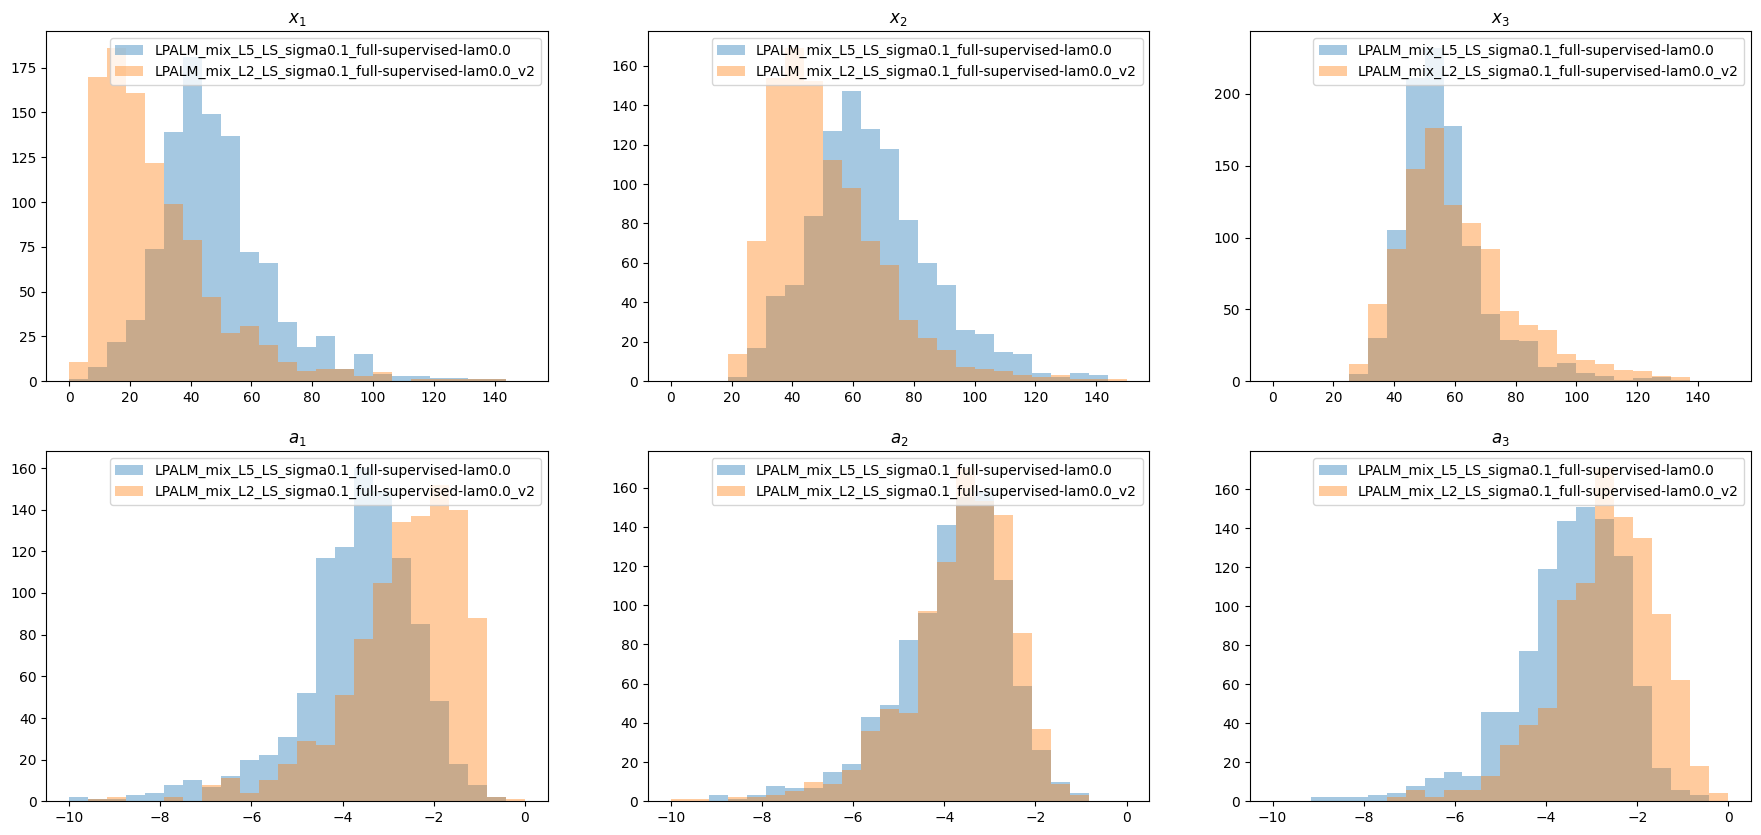

In [13]:
model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3')
]

bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
plt.figure(figsize=(22,10))
        
for fname in ['Models/models0621/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0',
             'Models/models0620/model_LPALM_mix_L']:
    sig = 0.1
    Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    model = LPALM_mix.load_model(fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    model_name = fname[fname.find('LPALM'):]
    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))
    for j in range(Xtest.shape[1]):
        plt.subplot(2,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
        plt.subplot(2,Xtest.shape[1],j+1+Xtest.shape[1])
        plt.hist(err_a[:,j],bins_a,alpha=0.4,label=model_name)
        plt.title('$a_%d$'%(j+1))
        plt.legend()

In [2]:
model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3')
]

bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
plt.figure(figsize=(22,10))

# fname='Models/models0910/model_GLPALM_LS_CNN_L10_sigma0.1_scaling1.0'
if fname.find('scaling')< 0: 
    sig = fname[fname.find('sigma')+5:]
    eps=0.
else:
    sig = fname[fname.find('sigma')+5:fname.find('_scaling')]
    eps = float(fname[fname.find('scaling')+7:])
if sig != 'inf':
    sig = float(sig)
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig, eps=eps)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
model = GLPALM.load_model(fname, device=device)

Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)
Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)

nmse_x=-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a=np.log(np.abs(Apred-Atest).squeeze()+1e-10)

print('GLPALM')
print('médiane de nmse_x: ',np.median(nmse_x,0))
print('médiane de err_a: ',np.median(err_a,0))
for j in range(Xtest.shape[1]):
    plt.subplot(2,Xtest.shape[1],j+1)
    plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='GLPALM')  
    plt.legend()

    plt.subplot(2,Xtest.shape[1],j+Xtest.shape[1]+1)
    plt.hist(err_a[:,j],bins_a,alpha=0.4,label='GLPALM')  
    plt.legend()

t1 = time.time()
X_est_list, A_est_list, itmax_list = PALM_LS(dataloader, model_IAE_list,eps=1e-6, mode_test=False)
t2 = time.time()
Xpred = torch.vstack(X_est_list).detach().numpy()
Apred = torch.vstack(A_est_list).detach().numpy()
nmse_x_PALM_LS = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a_PALM_LS = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
print('PALM: ')
print('médiane de nmse_x: ',np.median(nmse_x_PALM_LS,0))
print('médiane de err_a: ',np.median(err_a_PALM_LS,0))
  
for j in range(Xtest.shape[1]):
    plt.subplot(2,Xtest.shape[1],j+1)
    plt.hist(nmse_x_PALM_LS[:,j],bins_x,alpha=0.4,label='PALM')  
    plt.title('$x_%d$'%(j+1))
    plt.xlabel('NMSE(dB)')
    plt.legend()

    plt.subplot(2,Xtest.shape[1],j+Xtest.shape[1]+1)
    plt.hist(err_a_PALM_LS[:,j],bins_a,alpha=0.4,label='PALM')  
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()
# plt.savefig('./Figures/LPALM_PALM.png', bbox_inches='tight')

NameError: name 'generate_dataset_mixture' is not defined

<Figure size 2200x1000 with 0 Axes>

max amplitudes:  [7.48610331 7.48120026 7.77140138]
min amplitudes:  [0. 0. 0.]
mean amplitudes:  [0.77456924 0.75868386 0.75960985]
variance:  [1.17013358 1.12766477 1.13856951]
mean sum:  2.2928629587609537


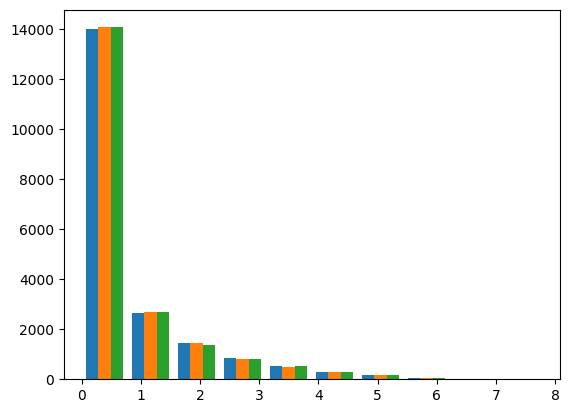

In [5]:
model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3')
]
sig = 'inf'
eps = 10.
# Y,A,X=generate_dataset_mixture(model_IAE_list, 20000, noise_level=[1e-3,1e-1],sigma_a=sig, eps=eps)
# with open('data/mixture_sigma'+str(sig)+'_scaling'+str(eps)+'.npy', "wb") as f:
#     pickle.dump([Y,A,X], f)
    

with open('data/mixture_sigma'+str(sig)+'_scaling'+str(eps)+'.npy', "rb") as f:
    Y, A, X = pickle.load(f)
    
plt.hist(A[:,:,0])
print('max amplitudes: ', A[:,:,0].max(0))
print('min amplitudes: ', A[:,:,0].min(0))
print('mean amplitudes: ', A[:,:,0].mean(0))
print('variance: ', A[:,:,0].var(0))
print('mean sum: ', A[:,:,0].sum(1).mean())
    
idx=16000    
Xtrain = X[:idx]
Ytrain = Y[:idx]
Atrain = A[:idx]
Xval = X[idx:]
Yval = Y[idx:]
Aval = A[idx:]

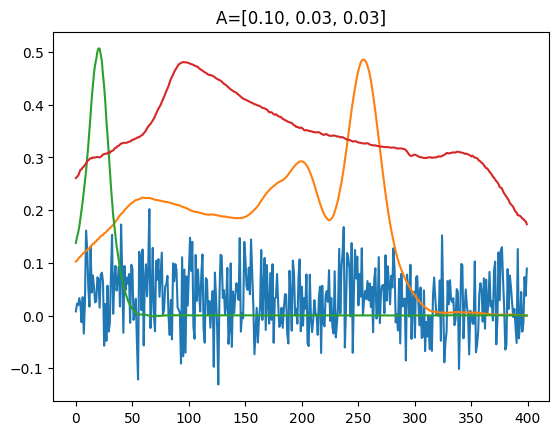

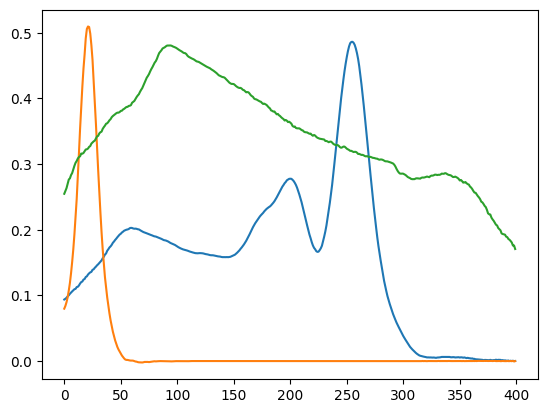

In [3]:
plt.plot(Y[1])
plt.plot(X[1,:,:,0].T)
plt.title('A=[%.2f, %.2f, %.2f]'%(A[1,0,0], A[1,1,0], A[1,2,0]))
plt.show()

Xpred = np.zeros((3,400,1))
#prediction FI
for j in range(3):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Y[1][None,:]).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred[j]=model_IAE_list[j].decode(B).detach().numpy()
plt.plot(Xpred[:,:,0].T)
plt.show()

max amplitudes:  [0.75927647 0.76793731 0.76143339]
min amplitudes:  [0. 0. 0.]
mean amplitudes:  [0.33362621 0.33189696 0.33447683]
variance:  [0.02431778 0.02456824 0.0246516 ]
sum:  [1. 1. 1. ... 1. 1. 1.]


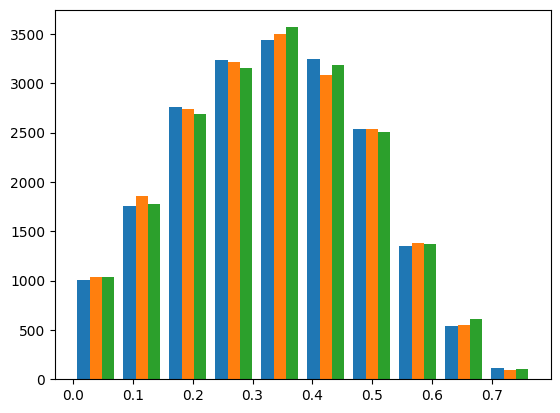

In [15]:
# def generate_dataset_mixture(model_IAE_list, nb_samples, noise_level=[1e-3, 1e-1], sigma_a = 0., sigma_s=0.):
#     X = []
#     for model_IAE in model_IAE_list:
#         if model_IAE.mean_lambda:
#             lam = torch.rand((nb_samples, model_IAE.num_ap), device=model_IAE.device).repeat(model_IAE.NLayers,1,1)
#         else:
#             lam = torch.rand((model_IAE.NLayers, nb_samples, model_IAE.num_ap), device=model_IAE.device)
#         lam = torch.einsum('ijk,ij->ijk', lam, 1. / torch.sum(lam, 2)) 
#         X.append(model_IAE.get_barycenter(lam).detach().numpy())
#     X = np.stack(X).transpose((1,0,2,3))

#     if sigma_a=="inf": # a random [0,1]
#         A = np.random.rand(X.shape[0],X.shape[1],X.shape[3]) / len(model_IAE_list) * 2.
#     else:
#         A = 1 / len(model_IAE_list) + sigma_a * np.random.randn(X.shape[0],X.shape[1],X.shape[3])
#     A = projection_simplex(A[:,:,0], axis=1)[:,:,None]   

#     if not sigma_s==0:
#         A = np.einsum('ijl,i->ijl', A, 1.+sigma_s * np.random.randn(X.shape[0]))


#     sigma = 10 ** (np.random.rand(X.shape[0]) * (np.log10(noise_level[1]/noise_level[0])) + np.log10(noise_level[0]))
#     Y = np.einsum('ijkl, ijl->ikl', X, A) + np.einsum('ijk,i->ijk', np.random.randn(X.shape[0],X.shape[2],X.shape[3]), sigma)
#     return Y, A, X

# Y,A,X=generate_dataset_mixture(model_IAE_list, 20000, noise_level=[1e-3,1e-1],sigma_a='inf', sigma_s=0.)

# plt.hist(A[:,:,0])
# print('max amplitudes: ', A[:,:,0].max(0))
# print('min amplitudes: ', A[:,:,0].min(0))
# print('mean amplitudes: ', A[:,:,0].mean(0))
# print('variance: ', A[:,:,0].var(0))
# print('sum: ', A[:,:,0].sum(1))

max amplitudes:  [0.36451401 0.36771126 0.36293207]
min amplitudes:  [0.2977359  0.29553359 0.30362384]
mean amplitudes:  [0.33331348 0.33339989 0.33328663]
variance:  [6.71855134e-05 6.68523620e-05 6.65266506e-05]


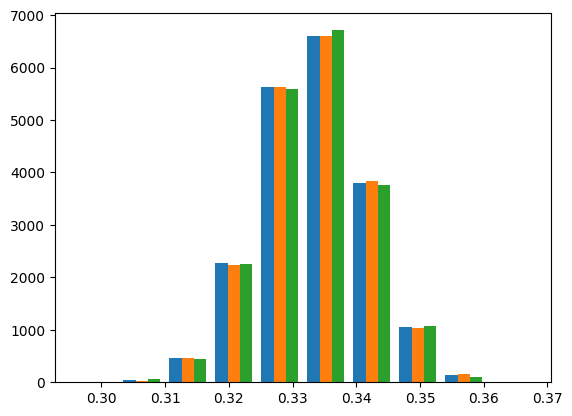

In [3]:
with open('data/mixture_sigma0.01.npy', "rb") as f:
    Y, A, X = pickle.load(f)

plt.hist(A[:,:,0])
print('max amplitudes: ', A[:,:,0].max(0))
print('min amplitudes: ', A[:,:,0].min(0))
print('mean amplitudes: ', A[:,:,0].mean(0))
print('variance: ', A[:,:,0].var(0))

# with open('data/data0717/mixture_sigmainf.npy', "rb") as f:
#     Y, A, X = pickle.load(f)

# plt.hist(A[:,:,0])
# print('max amplitudes: ', A[:,:,0].max(0))
# print('min amplitudes: ', A[:,:,0].min(0))
# print('mean amplitudes: ', A[:,:,0].mean(0))
# print('variance: ', A[:,:,0].var(0))

max amplitudes:  [0.99883385 0.99996641 0.99838268]
min amplitudes:  [0.00286613 0.0005222  0.00056979]
mean amplitudes:  [0.5078382  0.48557482 0.50154184]
variance:  [0.08723903 0.08211397 0.08904265]


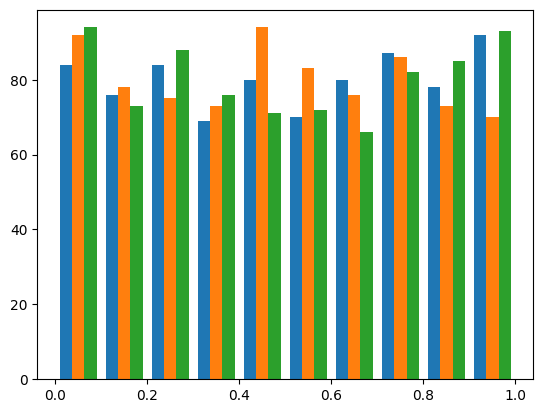

In [17]:
with open('data/data0717/mixture_sigmainf.npy', "rb") as f:
    Y, A, X = pickle.load(f)
    
Xtrain = X[:800]
Ytrain = Y[:800]
Atrain = A[:800]
Xval = X[800:]
Yval = Y[800:]
Aval = A[800:]
plt.hist(Atrain[:,:,0])
print('max amplitudes: ', Atrain[:,:,0].max(0))
print('min amplitudes: ', Atrain[:,:,0].min(0))
print('mean amplitudes: ', Atrain[:,:,0].mean(0))
print('variance: ', Atrain[:,:,0].var(0))

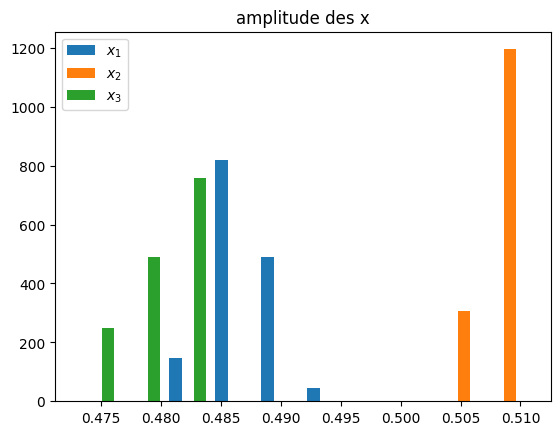

In [7]:
plt.hist(X.max(2).squeeze(), label=['$x_1$','$x_2$','$x_3$'])
plt.title('amplitude des x')
plt.legend()
plt.show()

/tmp/ipykernel_1672799/800720581.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.plot(model_IAE_list[j].anchorpoints[0,:,0].T, '--', color='black', label='Anchor points')


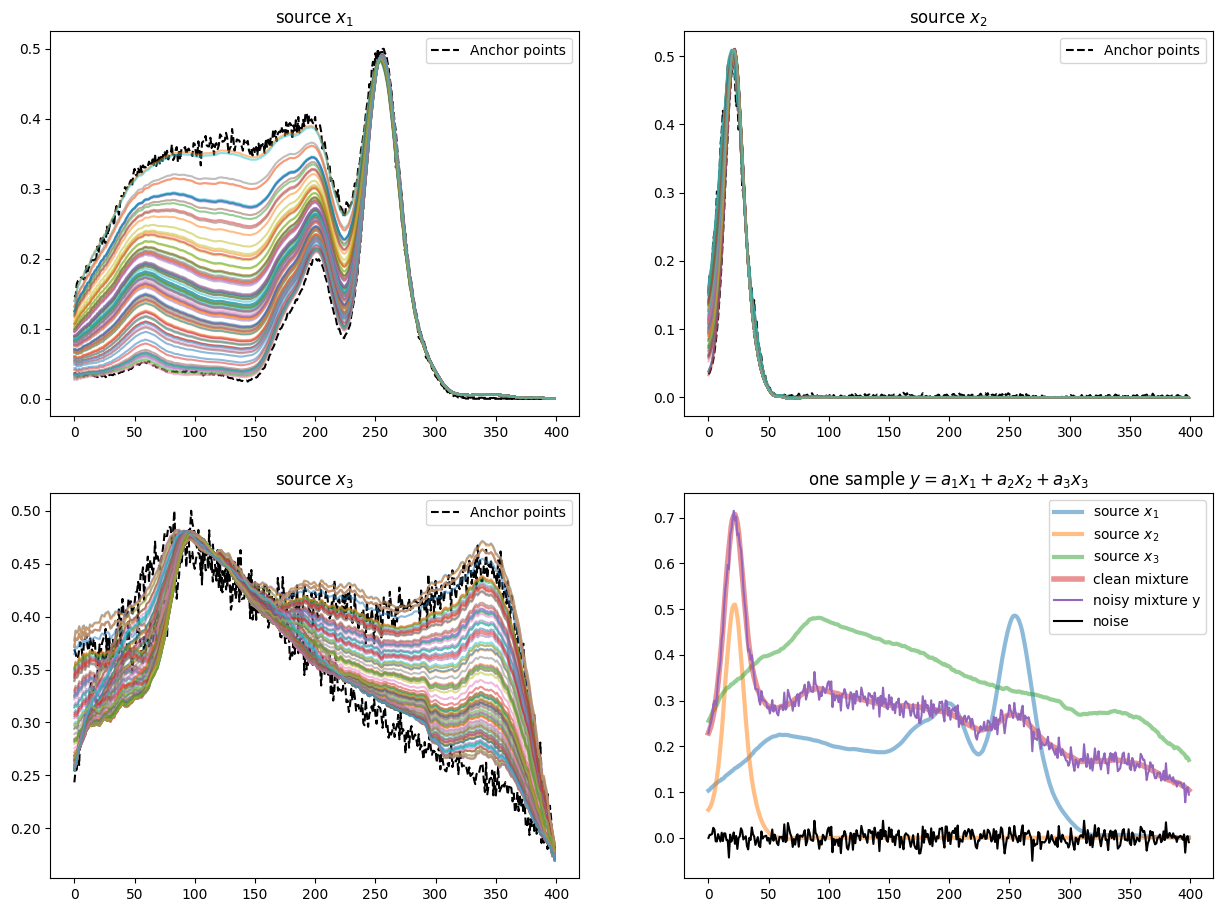

In [3]:
plt.figure(figsize=(15,11))
for j in range(Xtrain.shape[1]):
#     plt.subplot(1,Xtrain.shape[1],j+1)
    plt.subplot(2,2,j+1)
    plt.plot(model_IAE_list[j].anchorpoints[0,:,0].T, '--', color='black', label='Anchor points')
    plt.plot(model_IAE_list[j].anchorpoints[1:,:,0].mT, '--', color='black')
    plt.plot(Xtrain[:100,j,:,0].T, alpha=0.5)
    plt.title('source $x_%d$'%(j+1))
    plt.legend()
# plt.show()

i=2

plt.subplot(2,2,4)
for j in range(3):
    plt.plot(Xtrain[i,j,:,0].T,lw=3,alpha=0.5, label='source $x_%d$'%(j+1))
plt.plot(np.einsum('ijkl, ijl->ikl', Xtrain, Atrain)[i,:,0].T,lw=4,alpha=0.5, label='clean mixture')
plt.plot(Ytrain[i,:,0].T, label='noisy mixture y')
plt.plot(Ytrain[i,:,0].T-np.einsum('ijkl, ijl->ikl', Xtrain, Atrain)[i,:,0].T,'k', label='noise')
plt.legend()
plt.title('one sample $y=a_1x_1+a_2x_2+a_3x_3$')
# plt.savefig('./Figures/dataset_mix.png', bbox_inches='tight')
plt.show()

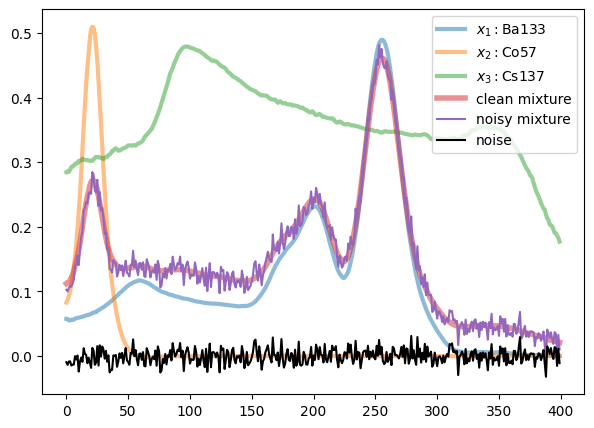

In [8]:
RN_NAME = ["Ba133","Co57","Cs137"]
# plt.figure(figsize=(22,5))
# for j in range(Xtrain.shape[1]):
#     plt.subplot(1,3,j+1)
#     plt.plot(model_IAE_list[j].anchorpoints[0,:,0].T, '--', color='black', label='Anchor points')
#     plt.plot(model_IAE_list[j].anchorpoints[1:,:,0].mT, '--', color='black')
#     plt.plot(Xtrain[:100,j,:,0].T, alpha=0.5)
#     plt.title('$x_%d:$'%(j+1)+RN_NAME[j])
#     plt.legend()
# plt.savefig('./Figures/dataset_manifolds.png', bbox_inches='tight')
# i=1
# plt.figure(figsize=(7,5))
# for j in range(3):
#     plt.plot(Xtrain[i,j,:,0].T,lw=3,alpha=0.5, label='$x_%d:$'%(j+1)+RN_NAME[j])
# plt.plot(np.einsum('ijkl, ijl->ikl', Xtrain, Atrain)[i,:,0].T,lw=4,alpha=0.5, label='clean mixture')
# plt.plot(Ytrain[i,:,0].T, label='noisy mixture')
# plt.plot(Ytrain[i,:,0].T-np.einsum('ijkl, ijl->ikl', Xtrain, Atrain)[i,:,0].T,'k', label='noise')
# plt.legend()
# # plt.title('one sample $y=a_1x_1+a_2x_2+a_3x_3+n$')
# plt.savefig('./Figures/dataset_mix_one_sample.png', bbox_inches='tight')
# plt.show()

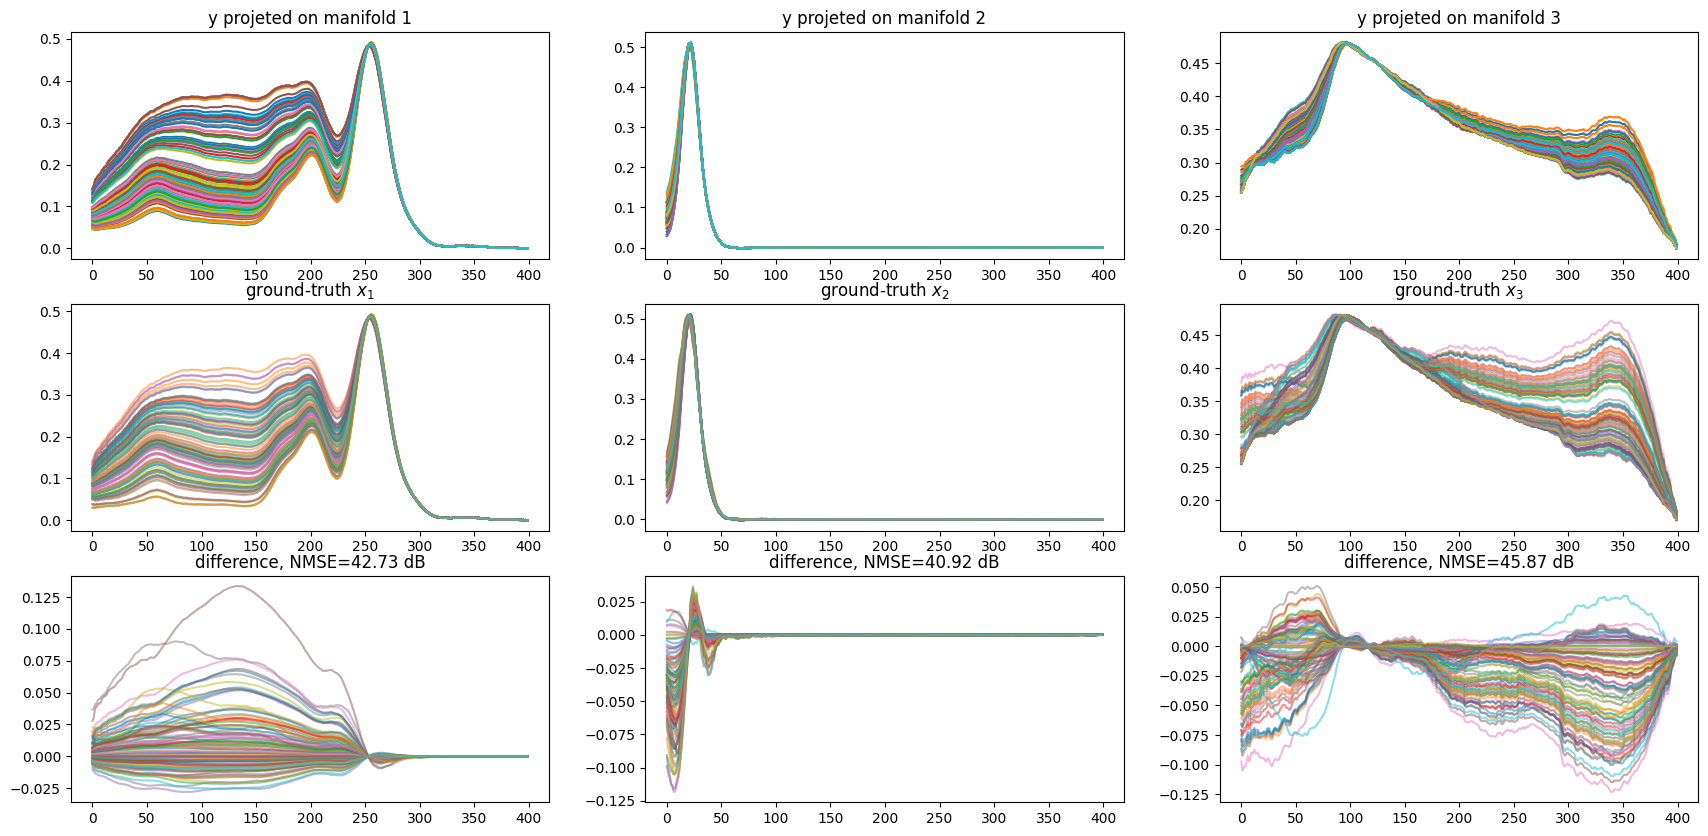

In [13]:
# project y on manifolds with FIs
plt.figure(figsize=(21,10))
for j in range(Xtrain.shape[1]):
    plt.subplot(3,Xtrain.shape[1],j+1)
    
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytrain[:100]).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()

    for _ in range(0):
        PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Xpred).float())
        B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
        Xpred = model_IAE_list[j].decode(B).detach().numpy()
        
    plt.plot(Xpred[:,:,0].T)  
    plt.title('y projeted on manifold %d'%(j+1))
    plt.subplot(3,Xtrain.shape[1],j+1+Xtrain.shape[1])
    plt.plot(Xtrain[:100,j,:,0].T, alpha=0.5)
    plt.title('ground-truth $x_%d$'%(j+1))
    plt.subplot(3,Xtrain.shape[1],j+1+2*Xtrain.shape[1])
    plt.plot(Xpred[:,:,0].T-Xtrain[:100,j,:,0].T, alpha=0.5)
    nmse = -20 * np.log10(((((Xpred[:,:,0]-Xtrain[:100,j,:,0])**2).sum(1)/((Xtrain[:100,j,:,0])**2).sum(1)).mean()))
    plt.title('difference, NMSE=%.2f dB'%nmse)
# plt.savefig('./Figures/unmixing_FI.png', bbox_inches='tight')
plt.show()

In [21]:
np.median(X.max(2),0)

array([[0.4870088],
       [0.5091877],
       [0.4802931]], dtype=float32)

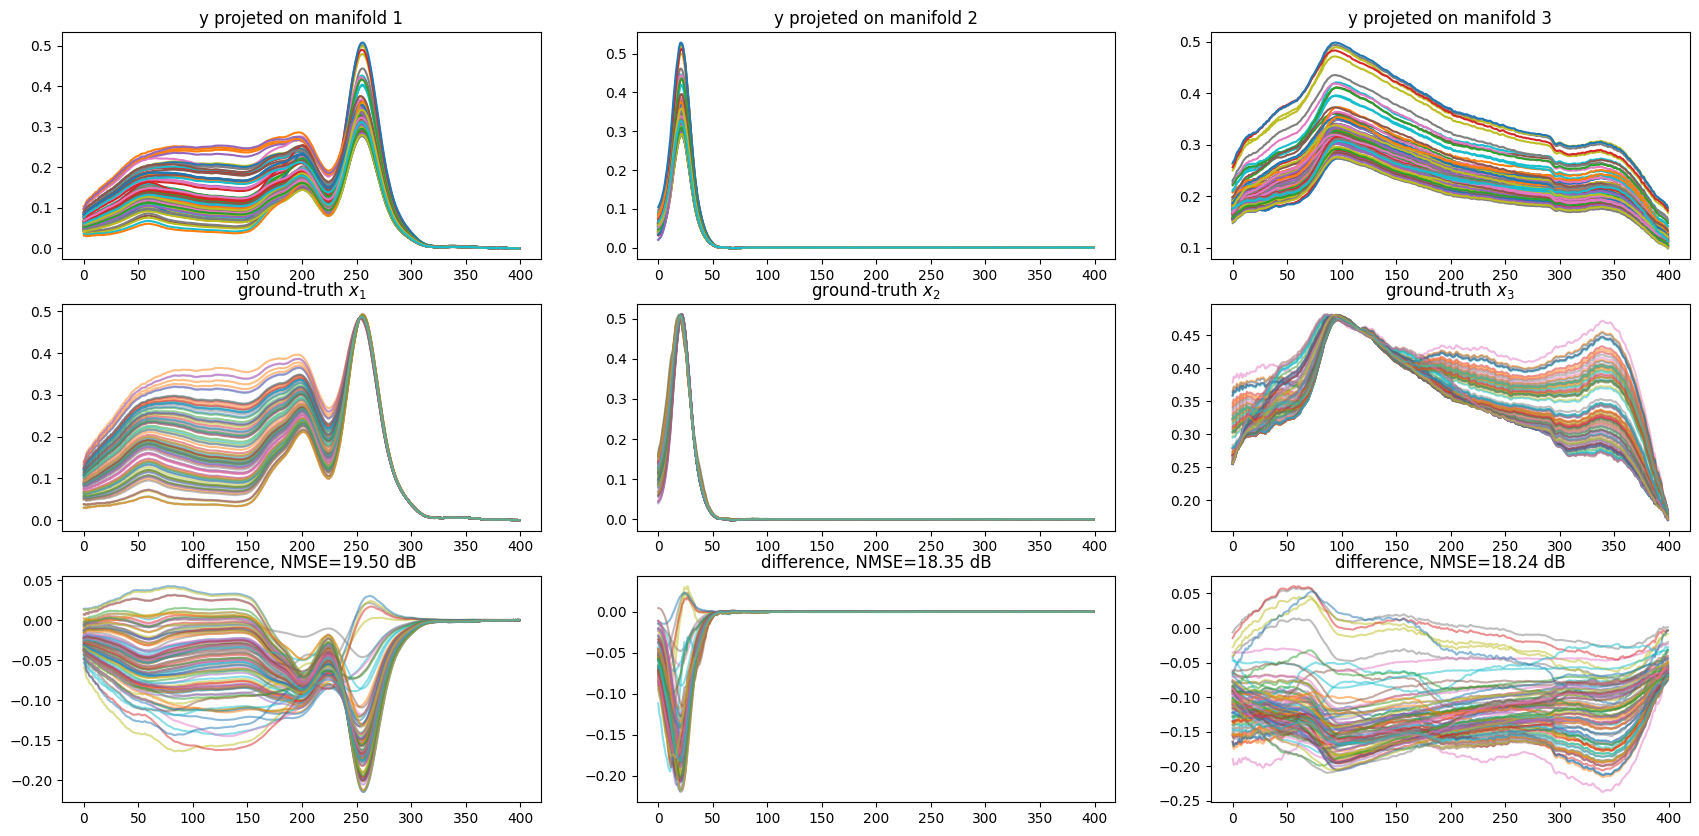

In [14]:
# project y on manifolds with FIs
plt.figure(figsize=(21,10))
for j in range(Xtrain.shape[1]):
    plt.subplot(3,Xtrain.shape[1],j+1)
    Xpred = model_IAE_list[j].fast_interpolation(Ytrain[:100])['XRec'].detach().numpy()
    for _ in range(0):
        Xpred = model_IAE_list[j].fast_interpolation(Xpred)['XRec'].detach().numpy()
        
    plt.plot(Xpred[:,:,0].T)  
    plt.title('y projeted on manifold %d'%(j+1))
    plt.subplot(3,Xtrain.shape[1],j+1+Xtrain.shape[1])
    plt.plot(Xtrain[:100,j,:,0].T, alpha=0.5)
    plt.title('ground-truth $x_%d$'%(j+1))
    plt.subplot(3,Xtrain.shape[1],j+1+2*Xtrain.shape[1])
    plt.plot(Xpred[:,:,0].T-Xtrain[:100,j,:,0].T, alpha=0.5)
    nmse = -20 * np.log10(((((Xpred[:,:,0]-Xtrain[:100,j,:,0])**2).sum(1)/((Xtrain[:100,j,:,0])**2).sum(1)).mean()))
    plt.title('difference, NMSE=%.2f dB'%nmse)
# plt.savefig('./Figures/unmixing_FI.png', bbox_inches='tight')
plt.show()

In [12]:
np.median(Ytrain.max(1))

0.3324784237094618

## Test models

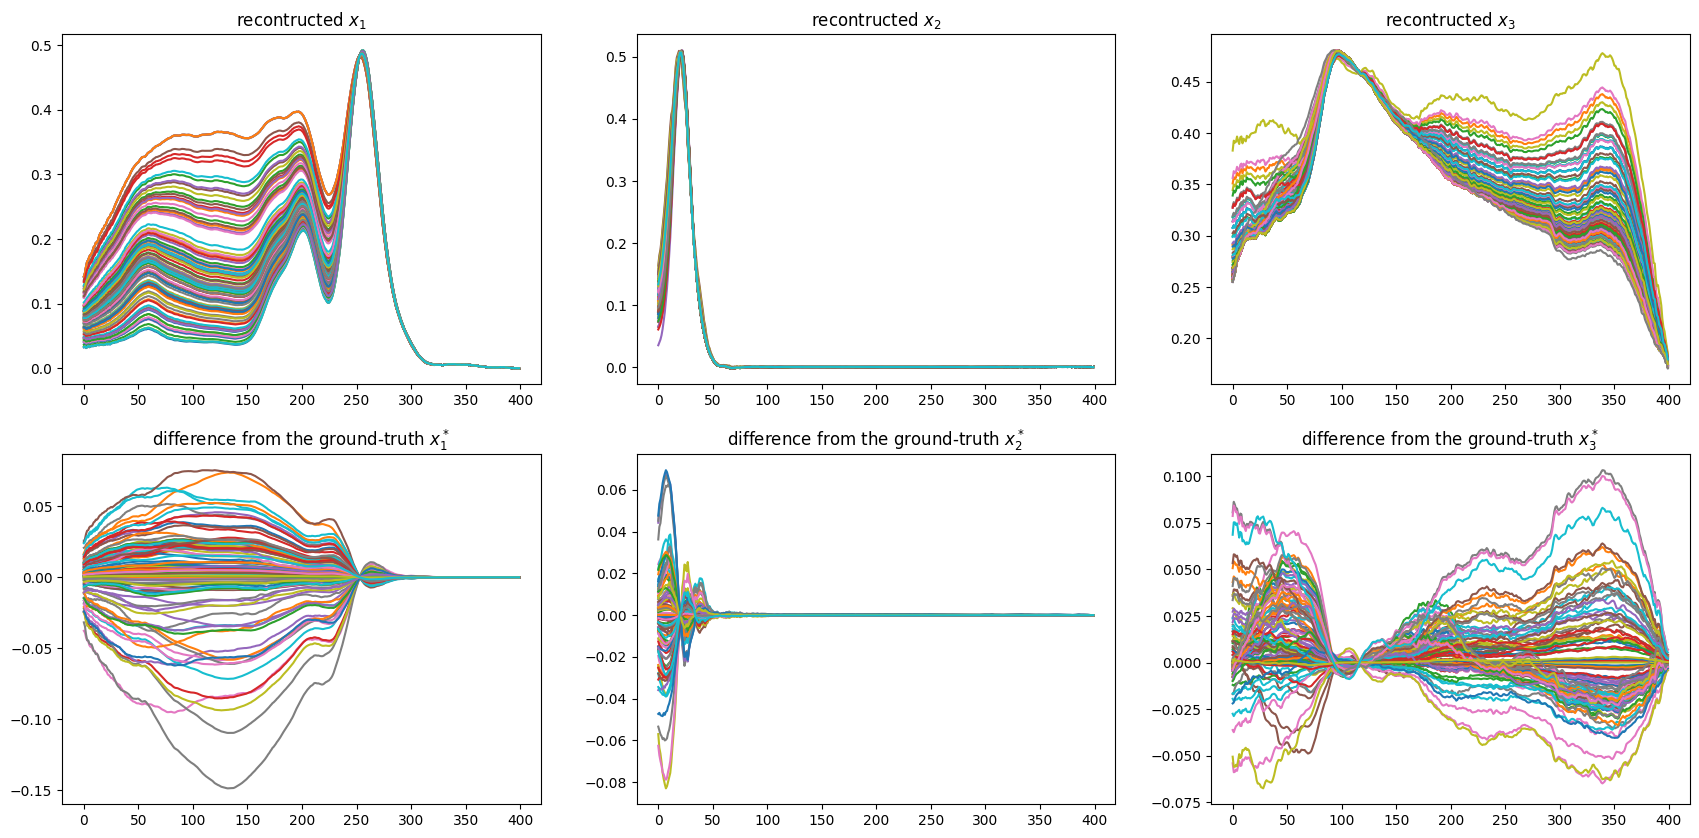

In [27]:
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 100, noise_level=[1e-3,1e-1],sigma_a=0.1)
model = LPALM_mix.load_model('Models/models0616/model_LPALM_mix_L8_LS_sigma0.1_full-supervised-lam1.0_init_cst', device=device)
plt.figure(figsize=(21,10))
for j in range(Xtest.shape[1]):
    plt.subplot(2,Xtest.shape[1],j+1)
    Apred, Xpred = model.forward(torch.tensor(Ytest).float().to(device))
    Apred = Apred[-1].cpu().detach().numpy()
    Xpred = Xpred[-1].cpu().detach().numpy()
    plt.plot(Xpred[:,j,:,0].T)  
    plt.title('recontructed $x_%d$'%(j+1))
    plt.subplot(2,Xtest.shape[1],j+1+Xtrain.shape[1])
    plt.plot(Xtest[:,j,:,0].T-Xpred[:,j,:,0].T)
    plt.title('difference from the ground-truth $x_%d^*$'%(j+1))
# plt.savefig('./Figures/Rec_sigma0.1.png', bbox_inches='tight')
plt.show()

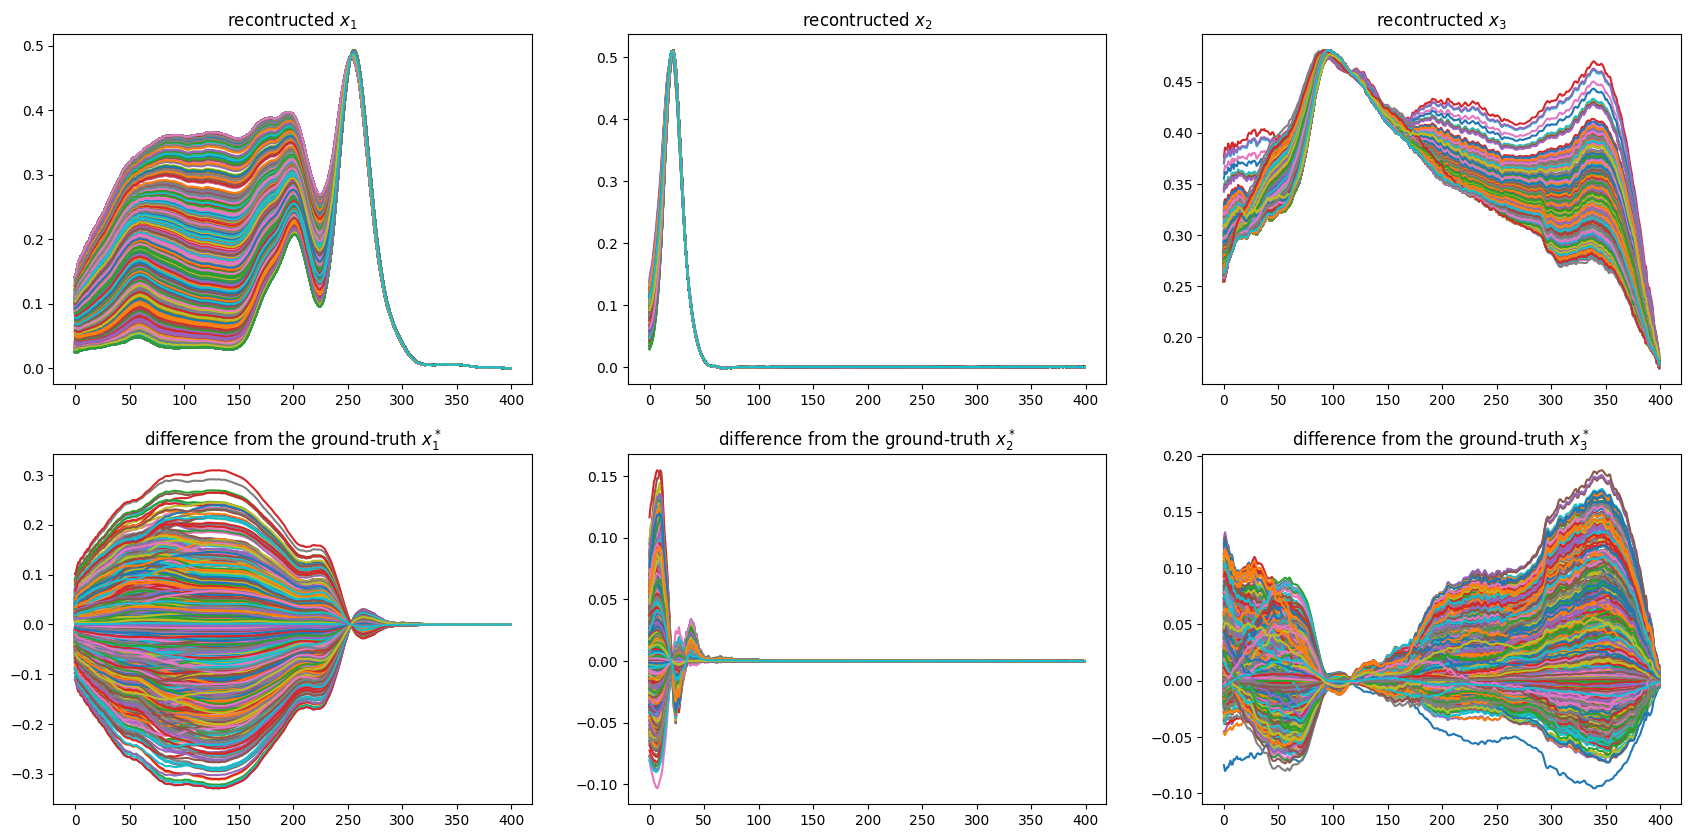

In [38]:
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a='inf')

plt.figure(figsize=(21,10))
for j in range(Xtest.shape[1]):

    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()

    for _ in range(0):
        PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Xpred).float())
        B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
        Xpred = model_IAE_list[j].decode(B).detach().numpy()

    plt.subplot(2,Xtest.shape[1],j+1)
    plt.plot(Xpred[:,:,0].T)  
    plt.title('recontructed $x_%d$'%(j+1))
    plt.subplot(2,Xtest.shape[1],j+1+Xtrain.shape[1])
    plt.plot(Xtest[:,j,:,0].T-Xpred[:,:,0].T)
    plt.title('difference from the ground-truth $x_%d^*$'%(j+1))
# plt.savefig('./Figures/Rec_FI_sigmainf.png', bbox_inches='tight')
plt.show()

LPALM_mix_L5_LS_sigmainf_full-supervised-lam0.0
médiane de nmse_x:  [28.014648 53.80621  50.61696 ]
médiane de err_a:  [-0.80762615 -0.92758679 -0.88229059]
LPALM_mix_L2_LS_sigmainf_full-supervised-lam0.0_v2
médiane de nmse_x:  [24.600754 52.389587 52.58922 ]
médiane de err_a:  [-0.78519322 -0.93324356 -0.90015113]


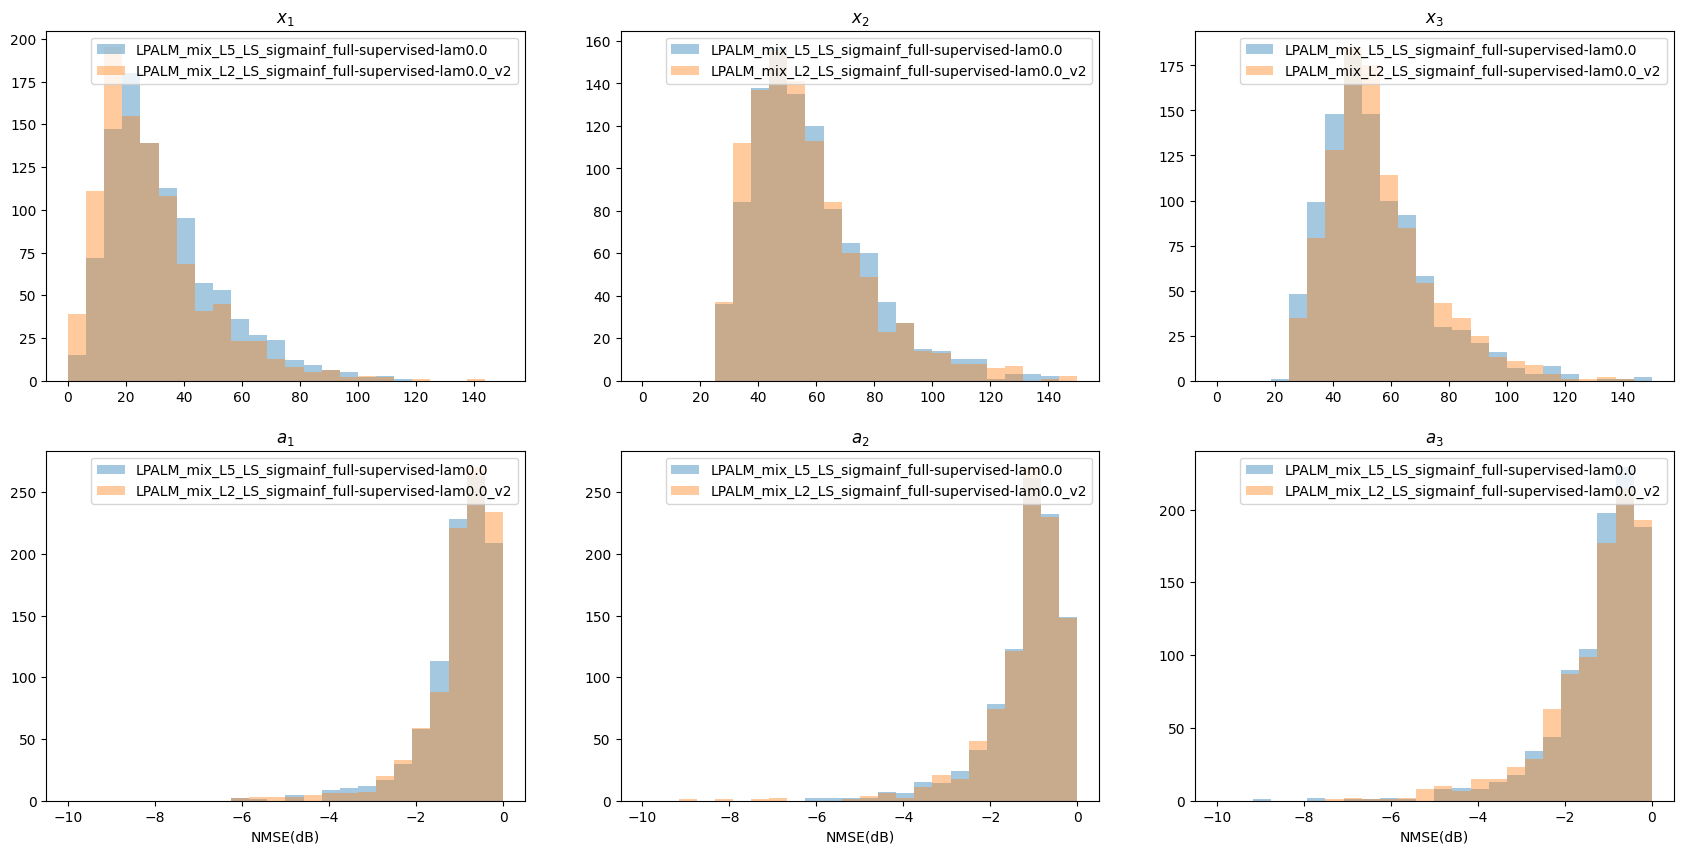

In [6]:
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a='inf')
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)

plt.figure(figsize=(21,10))

        
for fname in ['Models/model_LPALM_mix_L5_LS_sigmainf_full-supervised-lam0.0',
             'Models/model_LPALM_mix_L2_LS_sigmainf_full-supervised-lam0.0_v2']:
#     sig = float(fname[fname.find('sigma')+5:fname.find('_',fname.find('sigma'))])
#     Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
#     dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    model = LPALM_mix.load_model(fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    model_name = fname[fname.find('LPALM'):]
    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print(model_name)
#     print('médiane de nmse_x: ',np.median(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)),0))
#     print('médiane de err_a: ',np.median((np.abs(Apred-Atest)/np.abs(Atest)).squeeze(),0))
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))
    for j in range(Xtest.shape[1]):
        plt.subplot(2,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
        plt.subplot(2,Xtest.shape[1],j+1+Xtest.shape[1])
        plt.hist(err_a[:,j],bins_a,alpha=0.4,label=model_name)
        plt.title('$a_%d$'%(j+1))
        plt.xlabel('NMSE(dB)')
        plt.legend()
    
# print('FI: ')
# for j in range(Xtest.shape[1]):
#     PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
#     B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
#     Xpred = model_IAE_list[j].decode(B).detach().numpy()
#     nmse_x = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest**2).sum((1,2)))

#     plt.subplot(2,Xtest.shape[1],j+1)
#     plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label="FI")  
#     plt.title('$x_%d$'%(j+1))
#     plt.legend()
#     print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x[:,j],0)))

plt.show()
# plt.savefig('./Figures/_.png', bbox_inches='tight')


LPALM_mix_L6_LS_semi-supervised
médiane de nmse_x:  [45.162964 66.04544  57.525074]
médiane de err_a:  [-3.5401754  -3.84594895 -3.4616688 ]
LPALM_mix_L8_LS_semi-supervised
médiane de nmse_x:  [45.72885  66.09804  57.937706]
médiane de err_a:  [-3.54816038 -3.95263917 -3.38183642]
LPALM_mix_L8_LS_sigma0.1_full-supervised-lam1.0_init_cst
médiane de nmse_x:  [48.803436 64.867935 58.827553]
médiane de err_a:  [-3.52072869 -4.00727535 -3.30397044]


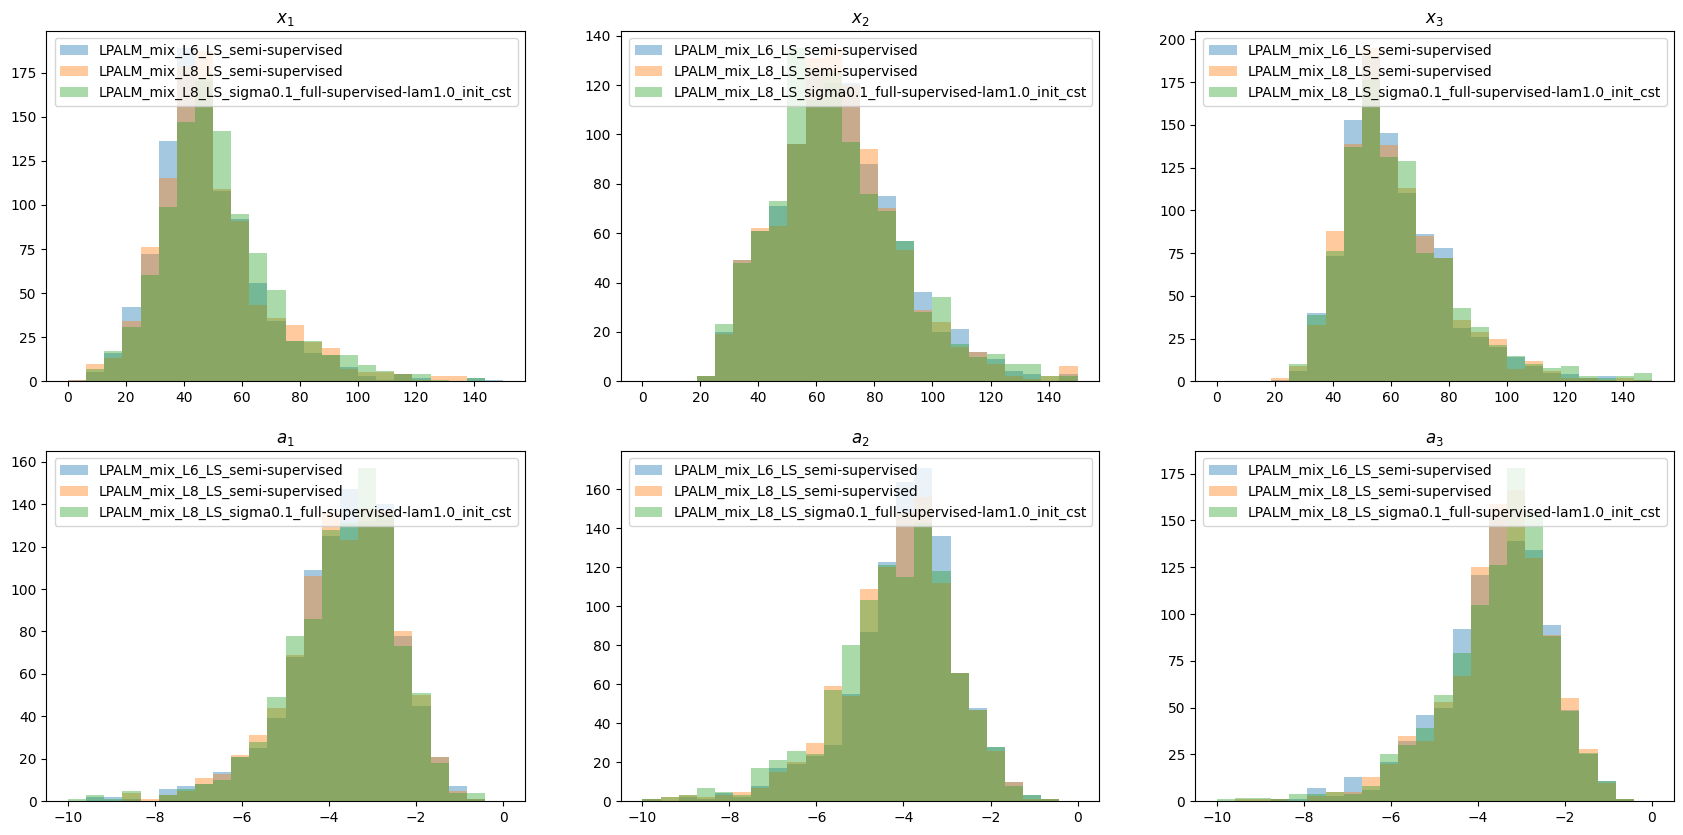

In [48]:
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=0.1)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)

plt.figure(figsize=(21,10))

for fname in ['Models/models0612/model_LPALM_mix_L6_LS_semi-supervised',
              'Models/models0612/model_LPALM_mix_L8_LS_semi-supervised',
             'Models/model_LPALM_mix_L8_LS_sigma0.1_full-supervised-lam1.0_init_cst']:
    model = LPALM_mix.load_model(fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    model_name = fname[fname.find('LPALM'):]
    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))
    for j in range(Xtest.shape[1]):
        plt.subplot(2,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
        plt.subplot(2,Xtest.shape[1],j+1+Xtest.shape[1])
        plt.hist(err_a[:,j],bins_a,alpha=0.4,label=model_name)
        plt.title('$a_%d$'%(j+1))
        plt.legend()

plt.show()

NLayers = 1
médiane de nmse_x:  [51.758587 44.522064 58.437088]
médiane de err_a:  [-3.36654997 -3.61637805 -3.35052305]
NLayers = 5
médiane de nmse_x:  [45.842392 52.483124 51.446777]
médiane de err_a:  [-3.61240896 -3.44437647 -3.23653074]
NLayers = 10
médiane de nmse_x:  [49.005157 52.65537  46.396416]
médiane de err_a:  [-3.21550888 -3.50714831 -2.88132384]


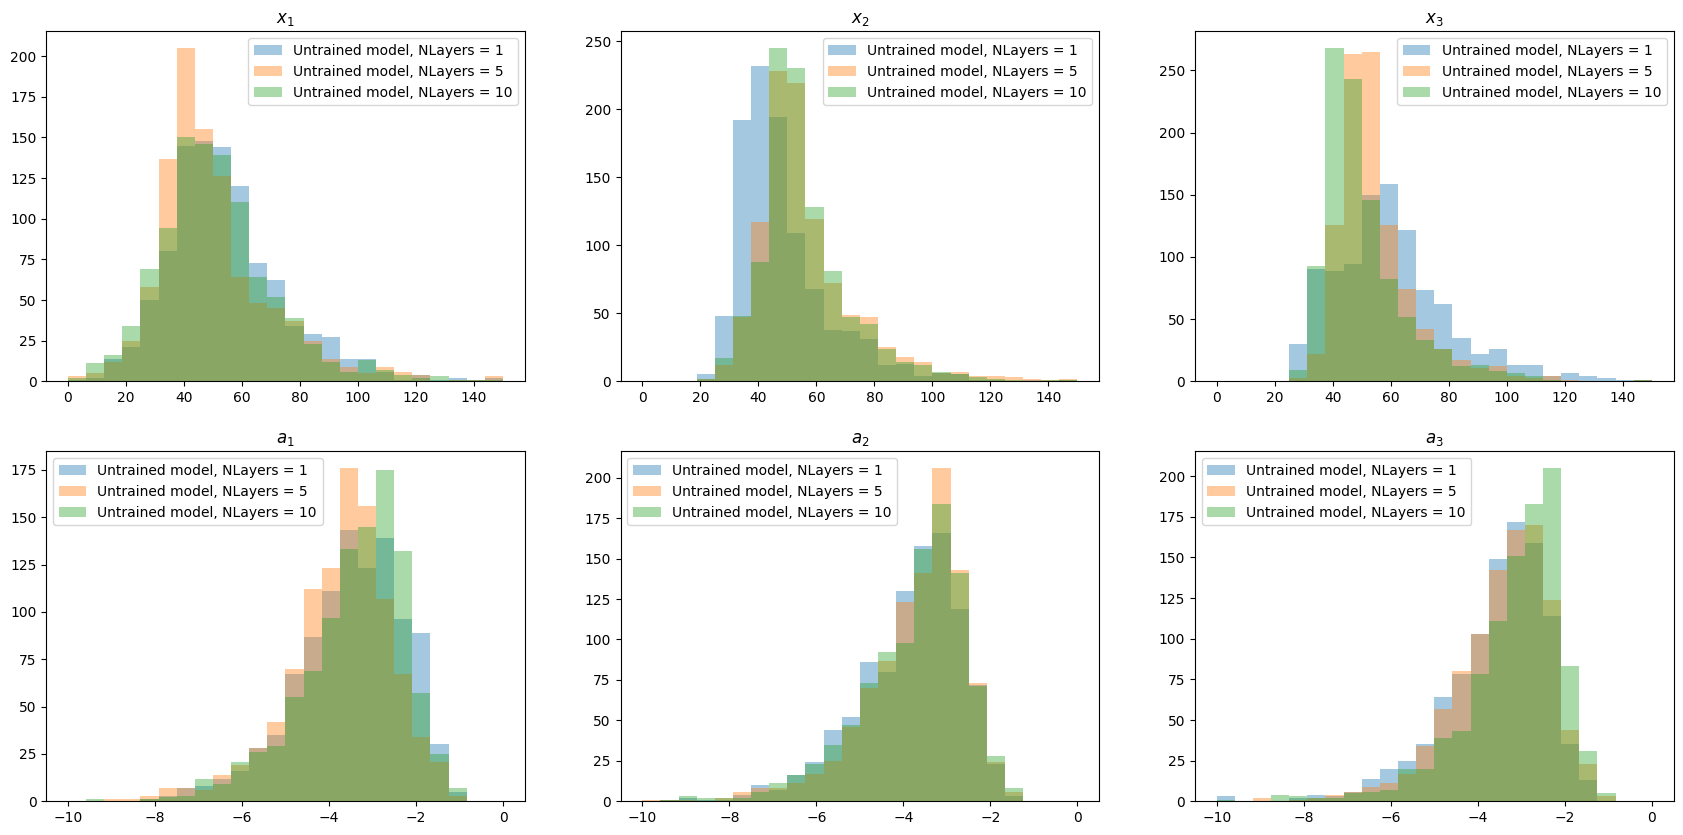

In [54]:
l = ['Models/cnn_test',
    'Models/cnn_test2',
    'Models/cnn_test3']

Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=0.01)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
plt.figure(figsize=(21,10))

for nlayers in [1,5,10]:
    arg_LPALM_mix = LPALM_mix.get_LPALM_mix_args(fname_list=l, NLayers=nlayers, update_A='LS', W_diag=True, device=device)
    model = LPALM_mix.LPALM_mix(arg_LPALM_mix).to(device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)

    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print('NLayers = %d'%nlayers)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))
    for j in range(Xtest.shape[1]):
        plt.subplot(2,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='Untrained model, NLayers = %d'%nlayers)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
        plt.subplot(2,Xtest.shape[1],j+1+Xtest.shape[1])
        plt.hist(err_a[:,j],bins_a,alpha=0.4,label='Untrained model, NLayers = %d'%nlayers)
        plt.title('$a_%d$'%(j+1))
        plt.legend()

LPALM_mix_L2_LS_sigma0.01_full-supervised-lam0.0_v2
médiane de nmse_x:  [24.690815 47.523754 58.138725]
médiane de err_a:  [-2.34713498 -3.48993011 -2.45830213]
LPALM_mix_L3_LS_sigma0.01_full-supervised-lam0.0_v2
médiane de nmse_x:  [35.86774 47.53875 51.14688]
médiane de err_a:  [-2.8929016  -3.38191029 -2.94574231]
FI: 
médiane de nmse_x: 50.14 dB
médiane de nmse_x: 43.81 dB
médiane de nmse_x: 58.52 dB


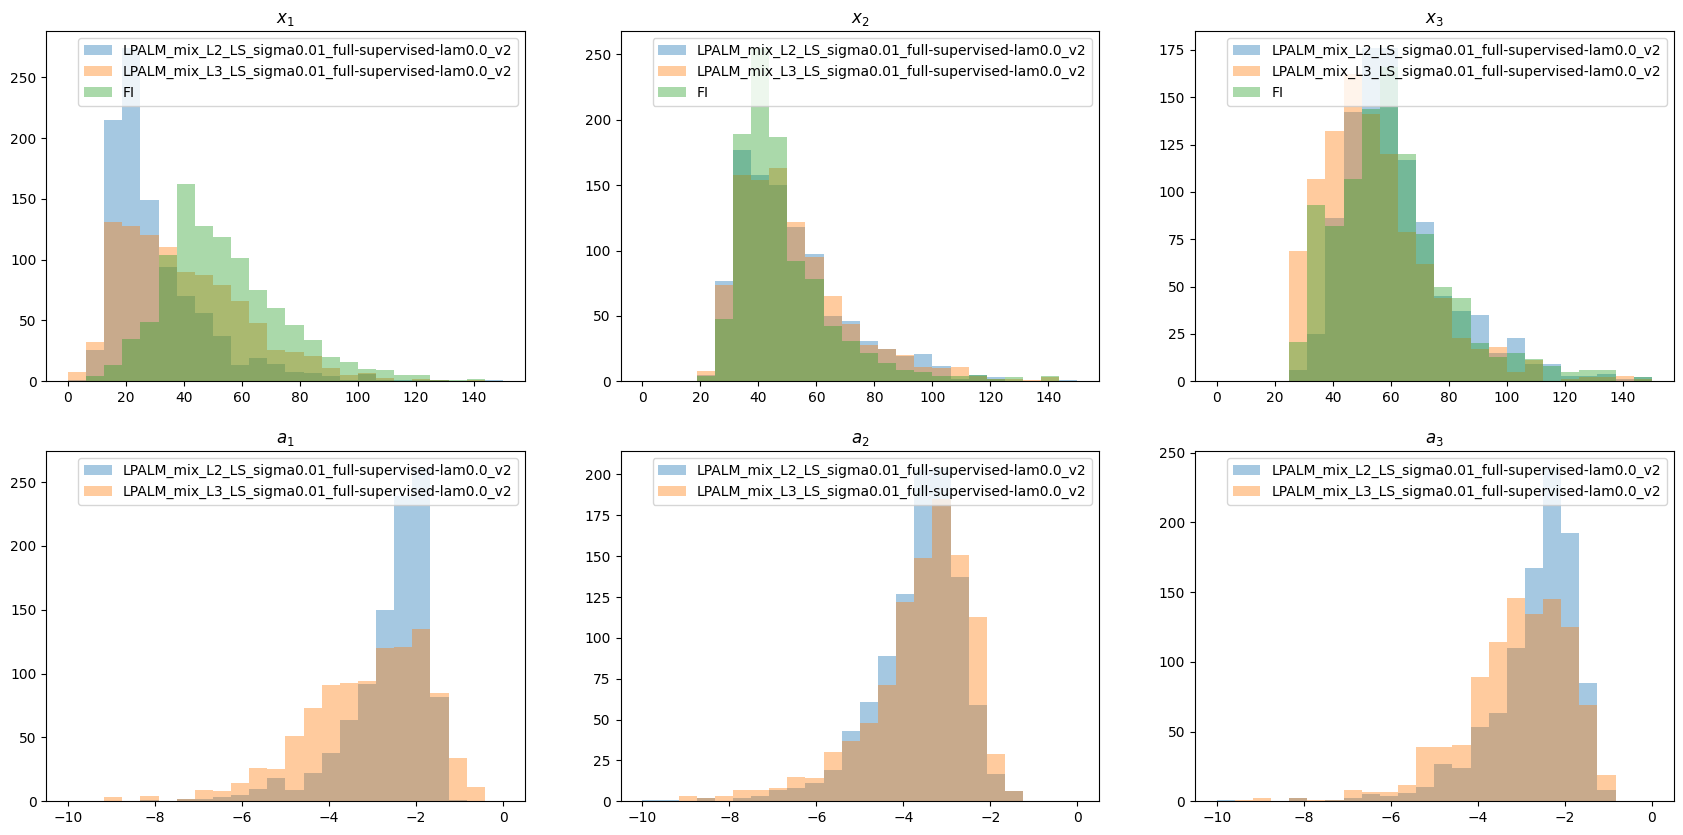

In [27]:
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=0.01)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)

plt.figure(figsize=(21,10))

for fname in ['Models/model_LPALM_mix_L2_LS_sigma0.01_full-supervised-lam0.0_v2',
              'Models/model_LPALM_mix_L3_LS_sigma0.01_full-supervised-lam0.0_v2']:
    model = LPALM_mix.load_model(fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    model_name = fname[fname.find('LPALM'):]
    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))
    for j in range(Xtest.shape[1]):
        plt.subplot(2,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
        plt.subplot(2,Xtest.shape[1],j+1+Xtest.shape[1])
        plt.hist(err_a[:,j],bins_a,alpha=0.4,label=model_name)
        plt.title('$a_%d$'%(j+1))
        plt.legend()
        
print('FI: ')        
for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(2,Xtest.shape[1],j+1)
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
# plt.savefig('./Figures/_.png', bbox_inches='tight')
plt.show()


LPALM_mix_L5_LS_sigma0.01
médiane de nmse_x:  [45.503975 68.664734 57.80913 ]
médiane de err_a:  [-3.52865129 -3.79465175 -3.49158677]
LPALM_mix_L5_LS_sigma0.1
médiane de nmse_x:  [43.933353 63.71046  56.219383]
médiane de err_a:  [-3.33117509 -3.77863163 -3.25822461]


/tmp/ipykernel_2903504/961855098.py:31: RuntimeWarning: divide by zero encountered in divide
  err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
/tmp/ipykernel_2903504/961855098.py:31: RuntimeWarning: invalid value encountered in divide
  err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())


LPALM_mix_L5_LS_sigmainf
médiane de nmse_x:  [25.107327 56.36975  57.293655]
médiane de err_a:  [        nan         nan -2.76389311]


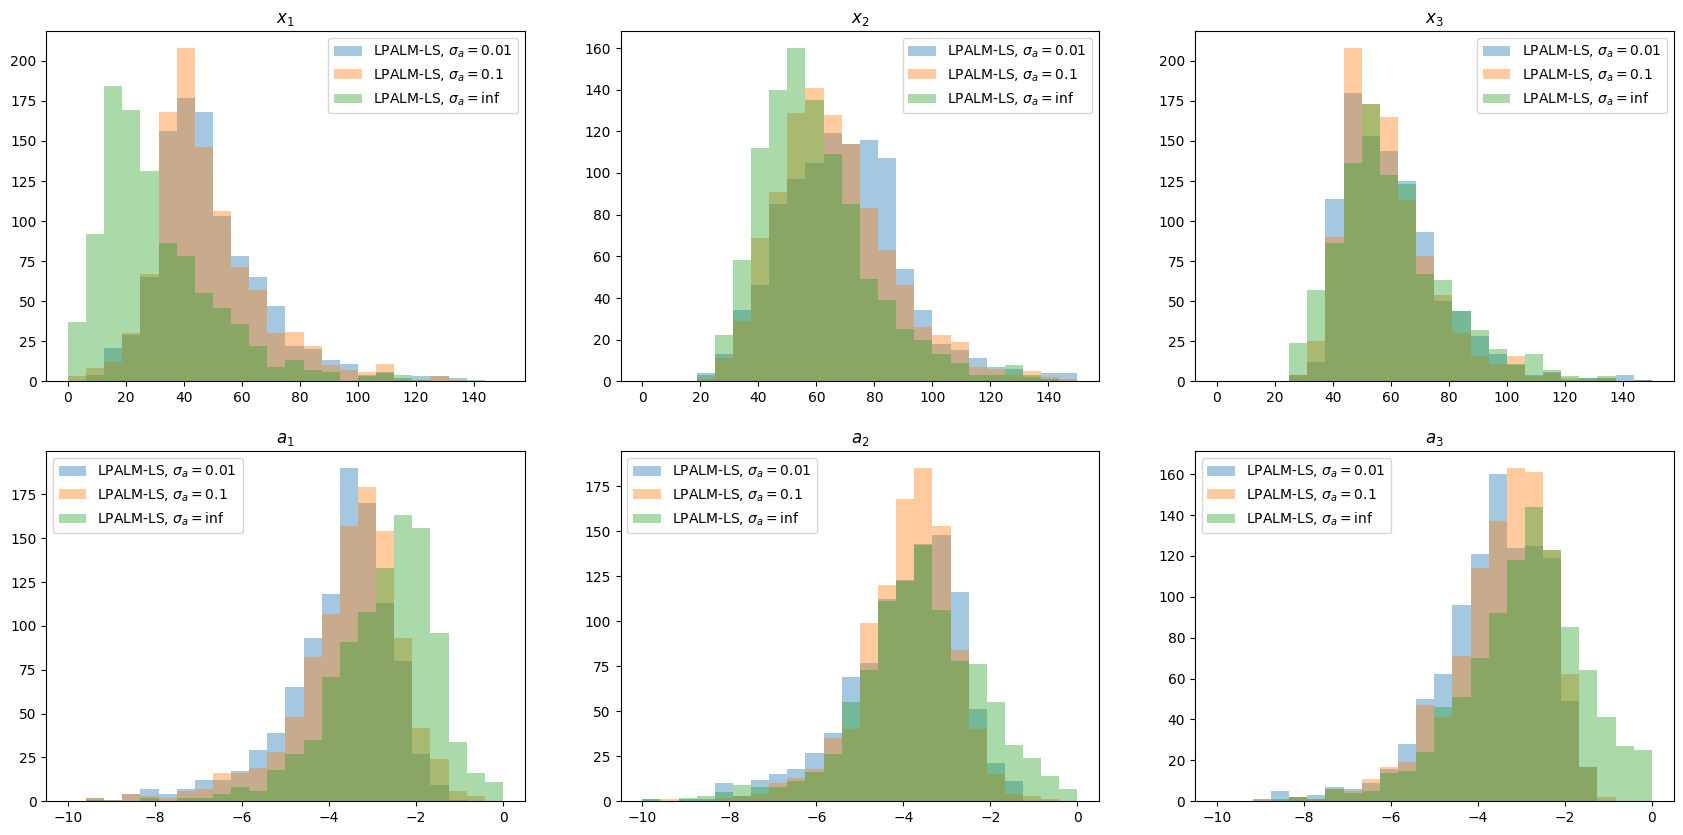

In [3]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)

plt.figure(figsize=(21,10))
        
for fname in ['Models/models0623/model_LPALM_mix_L5_LS_sigma0.01_full-supervised-lam0.0',
             'Models/models0623/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0',
             'Models/models0623/model_LPALM_mix_L5_LS_sigmainf_full-supervised-lam0.0']:
    sig = fname[fname.find('sigma')+5:fname.find('_',fname.find('sigma'))]
    if sig != 'inf':
        sig = float(sig)
        
    Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    model = LPALM_mix.load_model(fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    model_name = fname[fname.find('LPALM'):fname.find('_',fname.find('sigma'))]

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))

    for j in range(Xtest.shape[1]):
        plt.subplot(2,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='LPALM-LS, $\sigma_a =$'+str(sig))  
#         plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
        plt.subplot(2,Xtest.shape[1],j+1+Xtest.shape[1])
        plt.hist(err_a[:,j],bins_a,alpha=0.4,label='LPALM-LS, $\sigma_a =$'+str(sig))
#         plt.hist(err_a[:,j],bins_a,alpha=0.4,label=model_name)
        plt.title('$a_%d$'%(j+1))
        plt.legend()
        
plt.savefig('./Figures/LPALM_mix_sigma_a.png', bbox_inches='tight')


LPALM_mix_L5_LS_sigma0.01
médiane de nmse_x:  [44.986706 65.9836   57.401287]
médiane de err_a:  [-3.65671077 -3.73433648 -3.40439967]
FI:
médiane de nmse_x: 50.39 dB
médiane de nmse_x: 44.06 dB
médiane de nmse_x: 57.01 dB
LPALM_mix_L5_LS_sigma0.1
médiane de nmse_x:  [42.271088 60.224785 54.55208 ]
médiane de err_a:  [-3.55343543 -3.75047925 -3.31394951]
FI:
médiane de nmse_x: 32.26 dB
médiane de nmse_x: 44.73 dB
médiane de nmse_x: 54.03 dB
LPALM_mix_L5_LS_sigmainf
médiane de nmse_x:  [26.754332 48.060112 49.762604]
médiane de err_a:  [-0.83851483 -0.99193747 -0.92932114]
FI:
médiane de nmse_x: 20.96 dB
médiane de nmse_x: 48.45 dB
médiane de nmse_x: 52.17 dB


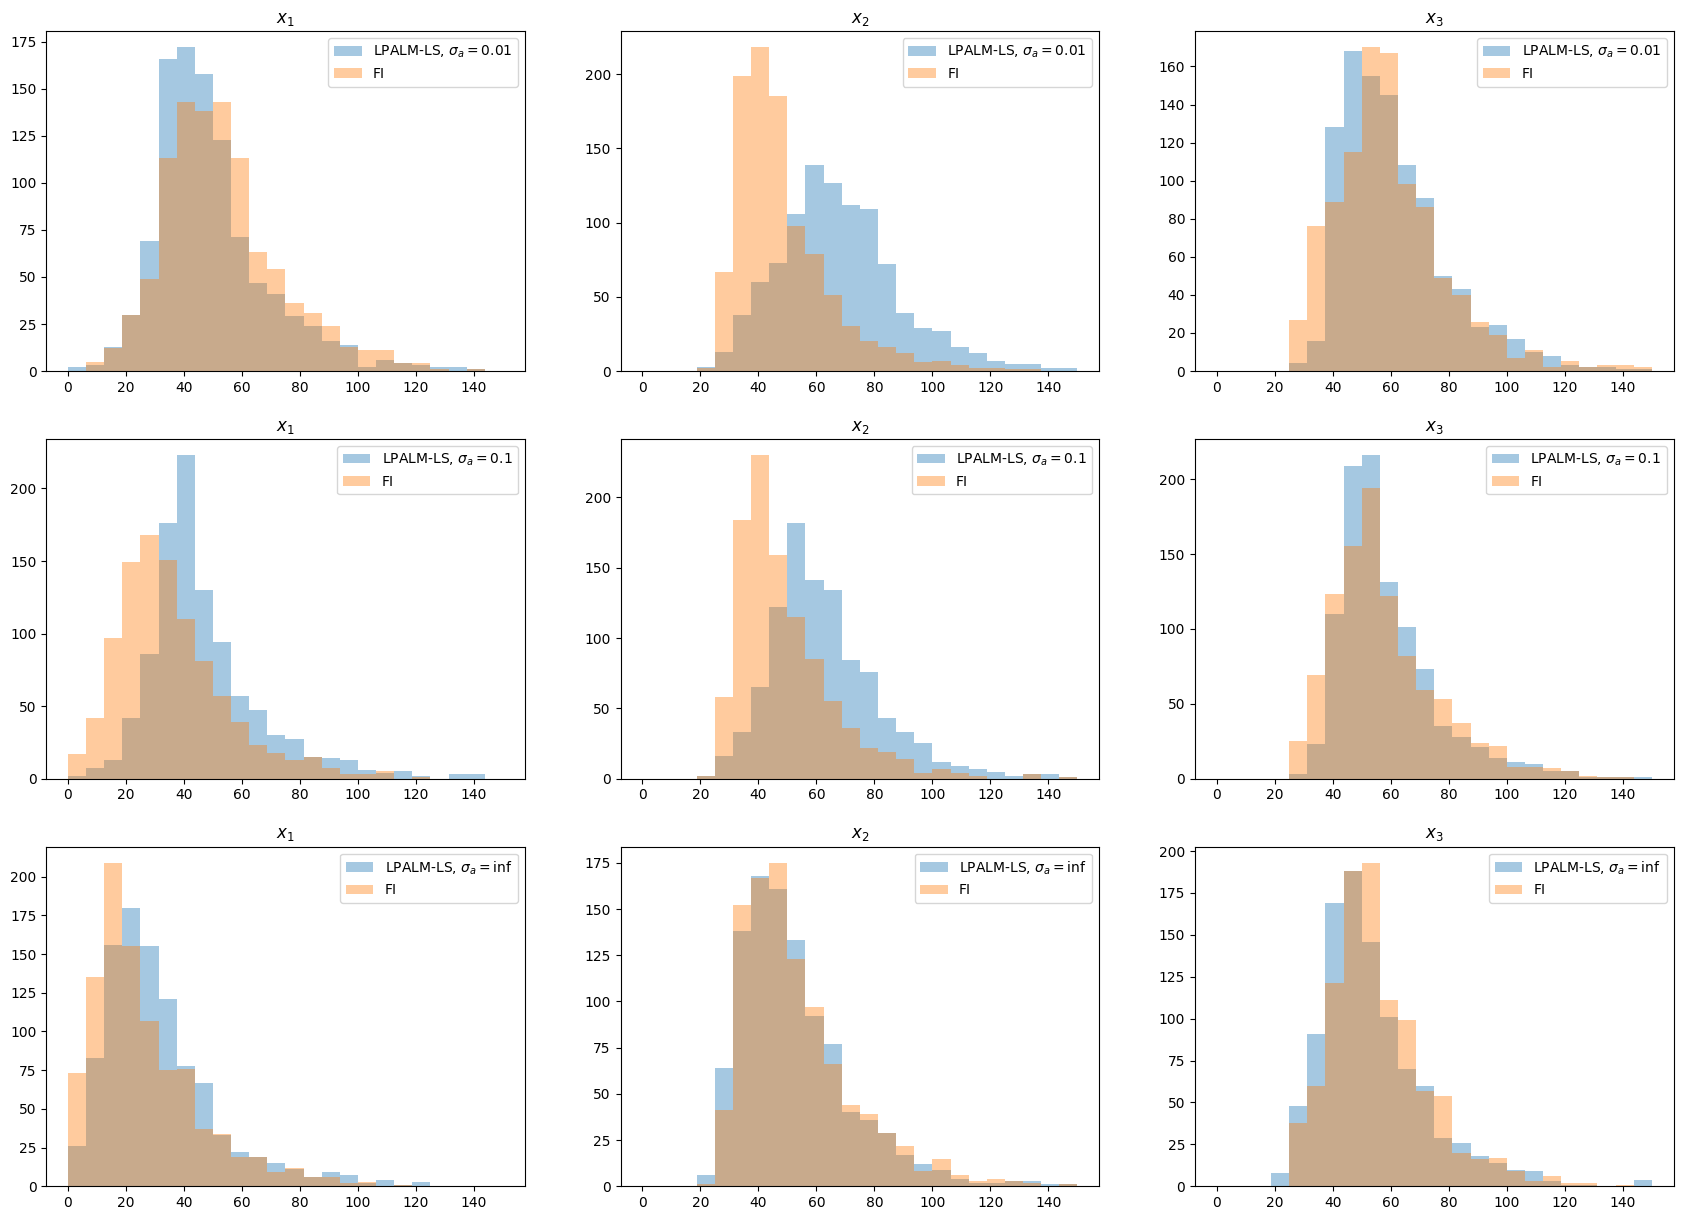

In [6]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
plt.figure(figsize=(21,15))
i_plot=0
for fname in ['Models/model_LPALM_mix_L5_LS_sigma0.01_full-supervised-lam0.0',
             'Models/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0',
             'Models/model_LPALM_mix_L5_LS_sigmainf_full-supervised-lam0.0']:
    sig = fname[fname.find('sigma')+5:fname.find('_',fname.find('sigma'))]
    if sig != 'inf':
        sig = float(sig)
        
    Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    model = LPALM_mix.load_model(fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    model_name = fname[fname.find('LPALM'):fname.find('_',fname.find('sigma'))]

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))

    print('FI:')
#     plt.figure(figsize=(22,5))
    Apred_FI = []
    Xpred_FI = []
    for j in range(Xtest.shape[1]):
        PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
        B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
        Xpred = model_IAE_list[j].decode(B).detach().numpy()
        
        for _ in range(0):
            PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Xpred).float())
            B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
            Xpred = model_IAE_list[j].decode(B).detach().numpy()
        nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

        plt.subplot(3,Xtest.shape[1],j+1+i_plot*Xtest.shape[1])
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='LPALM-LS, $\sigma_a =$'+str(sig))  
#         plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()

        plt.subplot(3,Xtest.shape[1],j+1+i_plot*Xtest.shape[1])
        plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
        print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
    i_plot += 1
#     plt.savefig('./Figures/LPALM_FI_sigma'+str(sig)+'.png', bbox_inches='tight')
# plt.savefig('./Figures/LPALM_FI.png', bbox_inches='tight')


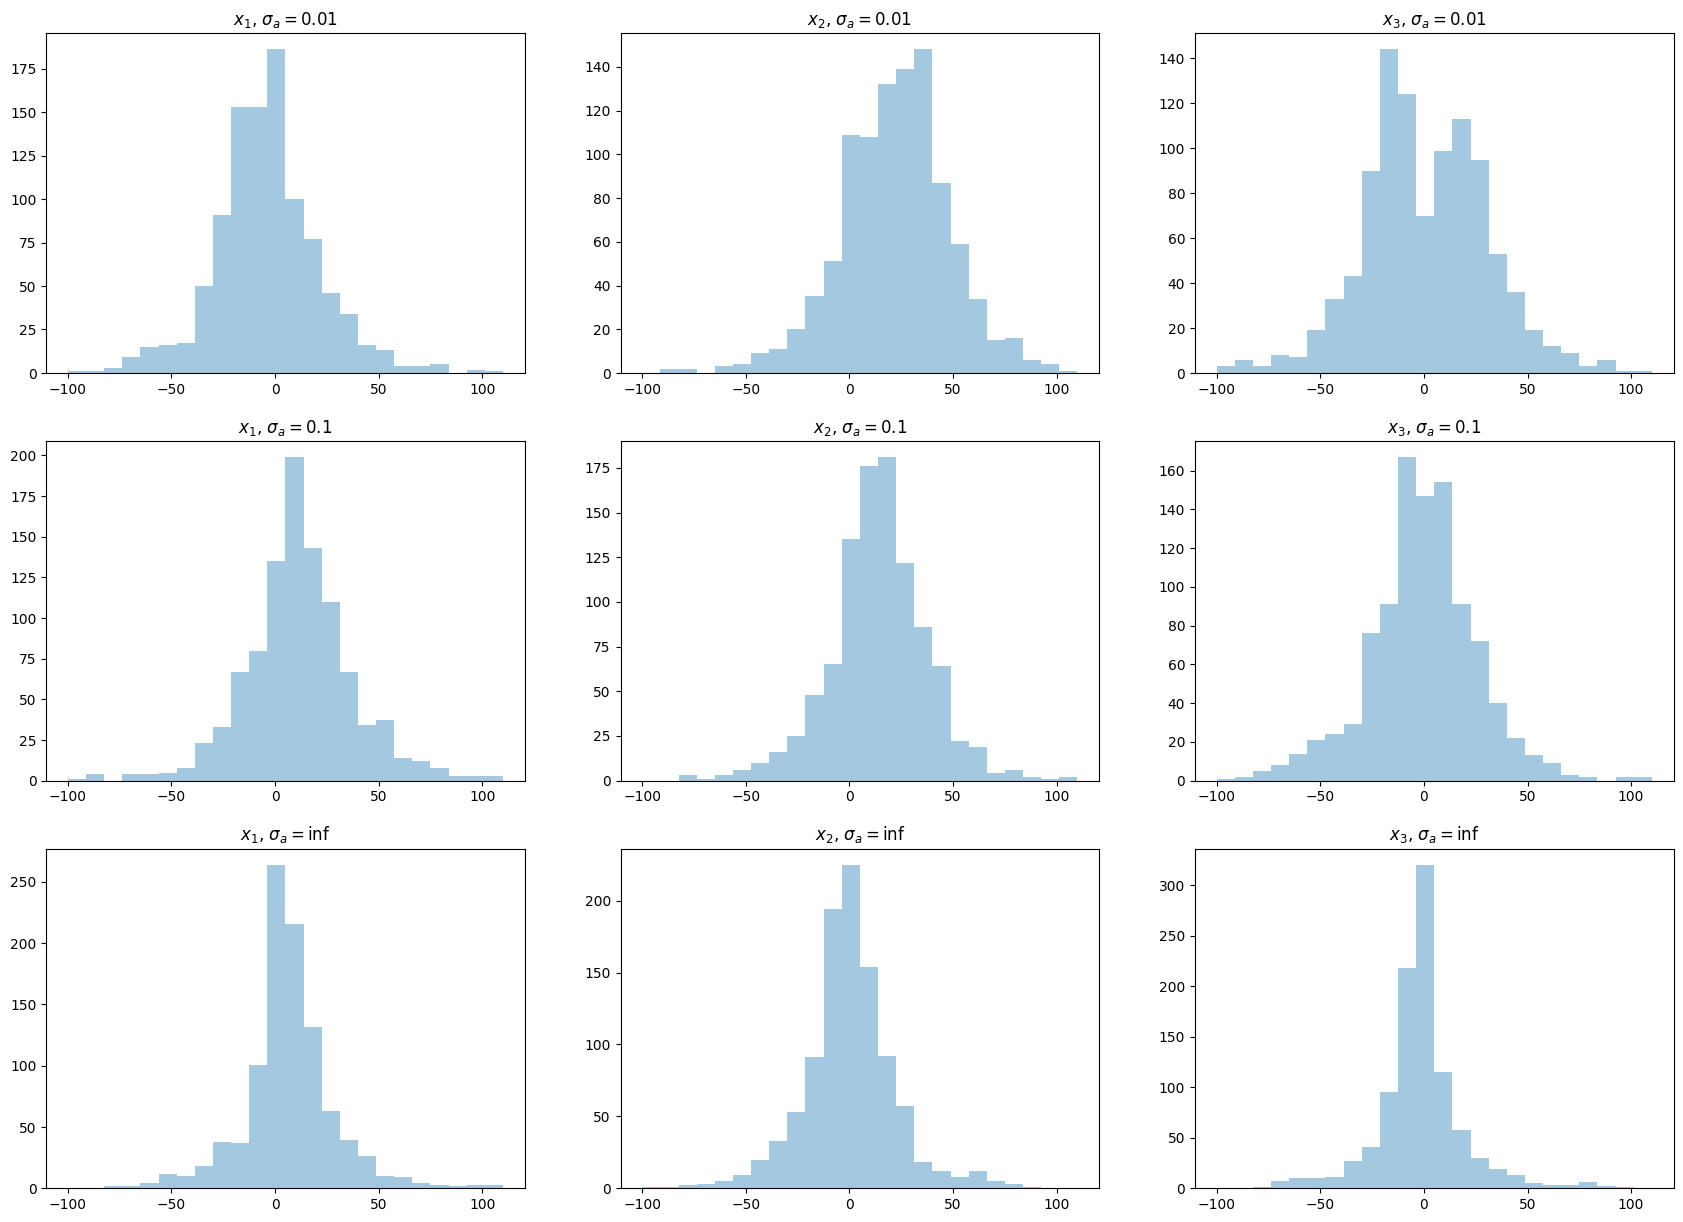

In [22]:
bins_x = np.linspace(-100, 110,25)
        
plt.figure(figsize=(21,15))
i_plot=0
for fname in ['Models/model_LPALM_mix_L5_LS_sigma0.01_full-supervised-lam0.0',
             'Models/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0',
             'Models/model_LPALM_mix_L5_LS_sigmainf_full-supervised-lam0.0']:
    sig = fname[fname.find('sigma')+5:fname.find('_',fname.find('sigma'))]
    if sig != 'inf':
        sig = float(sig)
        
    Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    model = LPALM_mix.load_model(fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    model_name = fname[fname.find('LPALM'):fname.find('_',fname.find('sigma'))]

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())

    Apred_FI = []
    Xpred_FI = []
    for j in range(Xtest.shape[1]):
        PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
        B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
        Xpred = model_IAE_list[j].decode(B).detach().numpy()
        
        for _ in range(0):
            PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Xpred).float())
            B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
            Xpred = model_IAE_list[j].decode(B).detach().numpy()
        nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

        plt.subplot(3,Xtest.shape[1],j+1+i_plot*Xtest.shape[1])
        plt.hist(nmse_x[:,j]-nmse_x_FI,bins_x,alpha=0.4)  
#         plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1)+', $\sigma_a =$'+str(sig))
        
#         print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
    i_plot += 1
# plt.savefig('./Figures/LPALM_FI_gain.png', bbox_inches='tight')


In [17]:
print(np.array([34.013824,52.816647,55.81698])-[22.01,48.54,52.04])
print(np.array([49.547295, 69.075905, 58.318718])-[50.70, 44.50, 57.56])
print(np.array([48.60528,  64.97067,  60.211952])-[30.54, 45.15, 56.16])


[12.003824  4.276647  3.77698 ]
[-1.152705 24.575905  0.758718]
[18.06528  19.82067   4.051952]


### PALM-LS (BCD)

In [11]:
t1= time.time()
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 10, noise_level=[1e-3,1e-1],sigma_a=0.01)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=10)
X_est_list, A_est_list, itmax_list = PALM_LS(dataloader, model_IAE_list,eps=1e-6)
print(time.time()-t1)

8.997161388397217


In [16]:
x_pred=X_est_list[0].squeeze().detach().numpy()
x_pred.shape

(5, 3, 400)

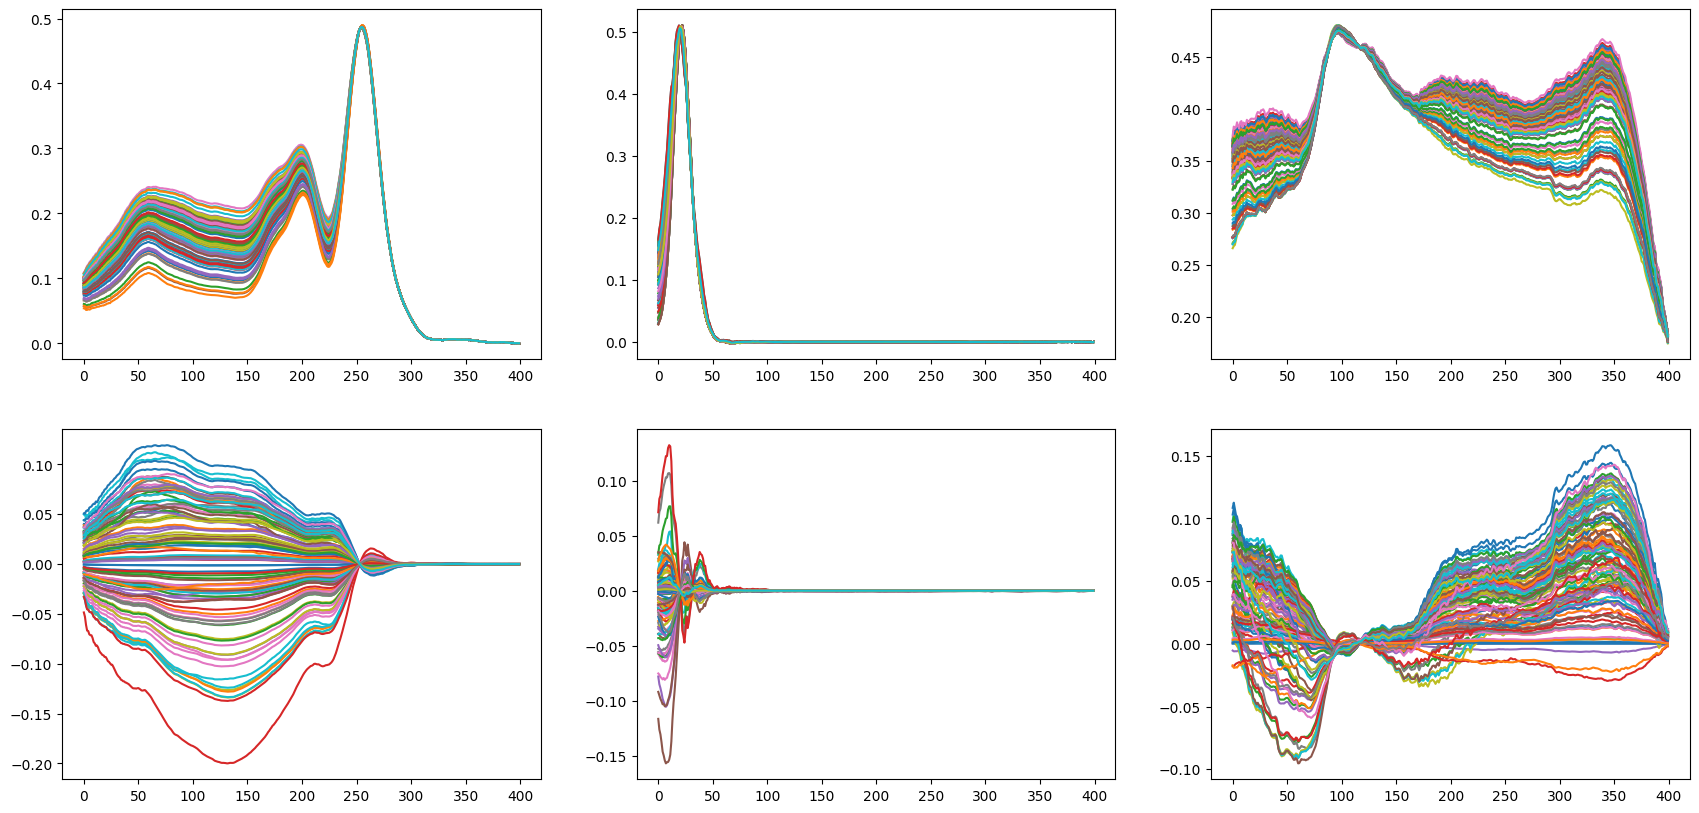

In [22]:
plt.figure(figsize=(21,10))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.plot(x_pred[:,i].T)
        
    plt.subplot(2,3,i+4)
    plt.plot((x_pred-Xtest.squeeze())[:,i].T)
plt.show()

In [ ]:
model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3')
]

bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
plt.figure(figsize=(21,15))
i_plot=0
for fname in ['Models/models0623/model_LPALM_mix_L5_LS_sigma0.01_full-supervised-lam0.0',
             'Models/models0623/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0',
             'Models/models0623/model_LPALM_mix_L5_LS_sigmainf_full-supervised-lam0.0']:
    sig = fname[fname.find('sigma')+5:fname.find('_',fname.find('sigma'))]
    if sig != 'inf':
        sig = float(sig)
        
    Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    model = LPALM_mix.load_model(fname, device=device)
    
    t1 = time.time()
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        with torch.no_grad():
            Apred_batch, Xpred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
        
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    
    t2 = time.time()
    model_name = fname[fname.find('LPALM'):fname.find('_',fname.find('sigma'))]

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))
    print('Temps de calcul: %.2f'%(t2-t1))
    
    t1 = time.time()
    X_est_list, A_est_list, itmax_list = PALM_LS(dataloader, model_IAE_list,eps=1e-6)
    t2 = time.time()
    Xpred = torch.vstack(X_est_list).detach().numpy()
    Apred = torch.vstack(A_est_list).detach().numpy()
    nmse_x_PALM_LS = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a_PALM_LS = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    print('PALM-LS: ')
    print('médiane de nmse_x: ',np.median(nmse_x_PALM_LS,0))
    print('médiane de err_a: ',np.median(err_a_PALM_LS,0))
    print(np.stack(itmax_list).mean(), np.stack(itmax_list).min(), np.stack(itmax_list).max())
    print('Temps de calcul: %.2f'%(t2-t1))

    # nmse_x_FI = []
    # t1 = time.time()
    # for j in range(Xtest.shape[1]):
    #     PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    #     B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    #     Xpred = model_IAE_list[j].decode(B).detach().numpy()
        
    #     for _ in range(0):
    #         PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Xpred).float())
    #         B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    #         Xpred = model_IAE_list[j].decode(B).detach().numpy()
    #     nmse_x_FI.append(-20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2))))
    # t2 = time.time()
    # print('FI:')
    # print('médiane de nmse_x: ', np.median(nmse_x_FI,1))
    # print('Temps de calcul: %.2f'%(t2-t1))
    
    for j in range(Xtest.shape[1]):
        plt.subplot(3,Xtest.shape[1],j+1+i_plot*Xtest.shape[1])
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='LPALM')  
        # plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='LPALM-LS, $\sigma_a =$'+str(sig))  
        plt.hist(nmse_x_PALM_LS[:,j],bins_x,alpha=0.4,label="PALM-LS") 
        # plt.hist(nmse_x_FI[j],bins_x,alpha=0.4,label="FI")  
        plt.title('$x_%d$'%(j+1))
        plt.legend()
    i_plot += 1
    plt.savefig('./Figures/LPALM_PALM_sigma'+str(sig)+'.png', bbox_inches='tight')
# plt.savefig('./Figures/LPALM_PALM_FI_.png', bbox_inches='tight')


LPALM_mix_L5_LS_sigma0.01
médiane de nmse_x:  [45.543785 68.313255 58.443066]
médiane de err_a:  [-3.60135406 -3.78253888 -3.41647201]
Temps de calcul: 1.94


In [ ]:
print(np.max(itmax_list))
print(np.min(itmax_list))
print(np.mean(itmax_list))

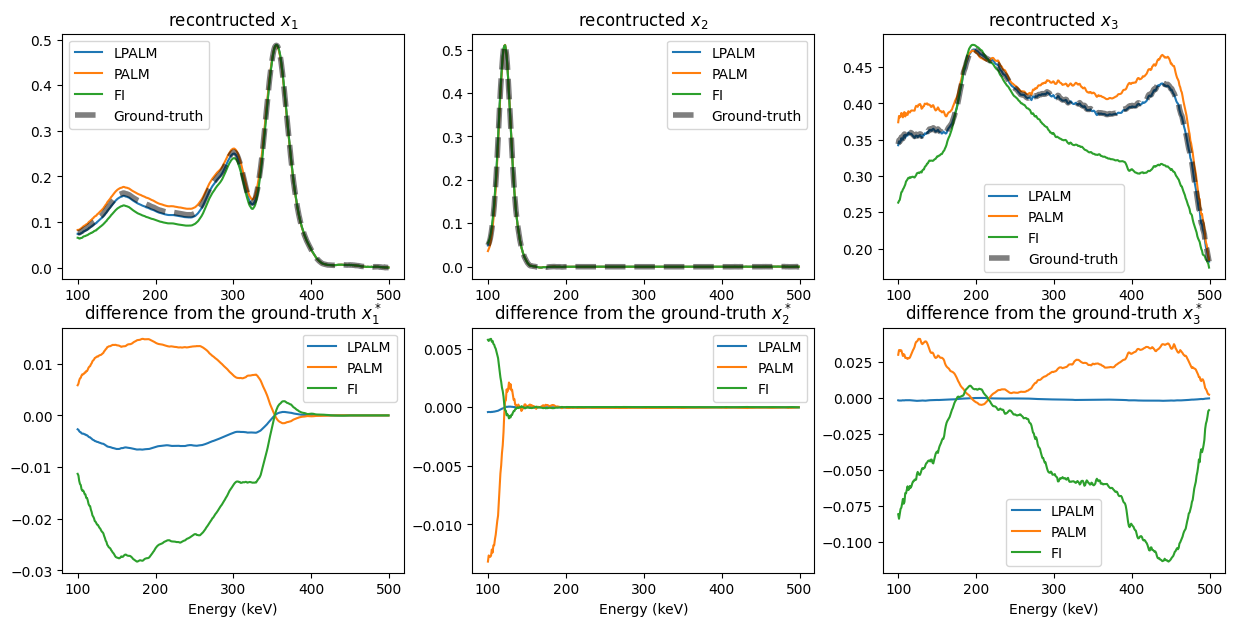

In [28]:
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 10, noise_level=[1e-3,1e-1],sigma_a=0.1)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
model = LPALM_mix.load_model('Models/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0', device=device)
#prediction LPALM-LS
Apred, Xpred = model.forward(torch.tensor(Ytest).float().to(device))
Apred = Apred[-1].cpu().detach().numpy()
Xpred = Xpred[-1].cpu().detach().numpy()
#prediction PALM-LS
X_est_list, A_est_list, itmax_list = PALM_LS(dataloader, model_IAE_list,eps=1e-6)
Xpred2 = torch.vstack(X_est_list).detach().numpy()
Apred2 = torch.vstack(A_est_list).detach().numpy()
#prediction FI
Xpred3=np.zeros(Xtest.shape)
for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred3[:,j]=model_IAE_list[j].decode(B).detach().numpy()

plt.figure(figsize=(15,7))
i = 2

# for j in range(Xtest.shape[1]):
#     plt.subplot(2,Xtest.shape[1],j+1)
#     plt.plot(Xpred[0,j,:,0].T,label='LPALM-LS')  
#     plt.plot(Xpred2[0,j,:,0].T,label='PALM-LS')  
#     plt.plot(Xpred3[0,j,:,0].T,label='FI')
#     plt.legend()
#     plt.title('recontructed $x_%d$'%(j+1))
#     plt.subplot(2,Xtest.shape[1],j+1+Xtrain.shape[1])
#     plt.plot(Xpred[0,j,:,0].T-Xtest[0,j,:,0].T,label='LPALM-LS')
#     plt.plot(Xpred2[0,j,:,0].T-Xtest[0,j,:,0].T,label='PALM-LS')
#     plt.plot(Xpred3[0,j,:,0].T-Xtest[0,j,:,0].T,label='FI')
#     plt.title('difference from the ground-truth $x_%d^*$'%(j+1))
#     plt.legend()
# # plt.savefig('./Figures/Exemples_sigma0.1.png', bbox_inches='tight')

energy=np.arange(100,500)
for j in range(Xtest.shape[1]):
    plt.subplot(2,Xtest.shape[1],j+1)
    plt.plot(energy,Xpred[i,j,:,0].T,label='LPALM',color='tab:blue')  
    plt.plot(energy,Xpred2[i,j,:,0].T,label='PALM',color='tab:orange')  
    plt.plot(energy,Xpred3[i,j,:,0].T,label='FI',color='tab:green')  
    plt.plot(energy,Xtest[i,j,:,0].T,label='Ground-truth',lw=4,alpha=0.5,color='k',linestyle='--')  
#     plt.plot(Xpred[i,j,:,0].T,color='tab:blue')  
#     plt.plot(Xpred2[i,j,:,0].T,alpha=0.5,color='tab:orange')  
#     plt.plot(Xpred3[i,j,:,0].T,alpha=0.5,color='tab:green')  
    plt.legend()
#     plt.xlabel('keV',loc='right')
    plt.title('recontructed $x_%d$'%(j+1))
    plt.subplot(2,Xtest.shape[1],j+1+Xtrain.shape[1])
    plt.plot(energy,Xpred[i,j,:,0].T-Xtest[i,j,:,0].T,label='LPALM',color='tab:blue')
    plt.plot(energy,Xpred2[i,j,:,0].T-Xtest[i,j,:,0].T,label='PALM',color='tab:orange')
    plt.plot(energy,Xpred3[i,j,:,0].T-Xtest[i,j,:,0].T,label='FI',color='tab:green')
#     plt.plot(Xpred[i,j,:,0].T-Xtest[i,j,:,0].T,color='tab:blue')
#     plt.plot(Xpred2[i,j,:,0].T-Xtest[i,j,:,0].T,alpha=0.5,color='tab:orange')
#     plt.plot(Xpred3[i,j,:,0].T-Xtest[i,j,:,0].T,alpha=0.5,color='tab:green')
    plt.title('difference from the ground-truth $x_%d^*$'%(j+1))
    plt.legend()
    plt.xlabel('Energy (keV)')
plt.savefig('./Figures/Exemple2_sigma0.1.png', bbox_inches='tight')
plt.show()

In [35]:
itmax_list[0]

tensor([ 87.,  57., 140., 145.,  93.,  56., 115., 108., 202.,  93.])

In [29]:
# sigma_a=0.01
print(torch.vstack(itmax_list).max(1).values)
print(torch.vstack(itmax_list).min(1).values)
print(torch.vstack(itmax_list).mean(1))

tensor([186.])
tensor([32.])
tensor([79.2100])


In [22]:
# sigma_a=0.1
print(torch.vstack(itmax_list).max(1).values)
print(torch.vstack(itmax_list).min(1).values)
print(torch.vstack(itmax_list).mean(1))

tensor([417.])
tensor([36.])
tensor([84.4400])


In [33]:
# sigma_a=inf
print(torch.vstack(itmax_list).max(1).values)
print(torch.vstack(itmax_list).min(1).values)
print(torch.vstack(itmax_list).mean(1))
print(torch.vstack(itmax_list).var(1))

tensor([381.])
tensor([25.])
tensor([58.4200])
tensor([1788.6299])


## Generative model

### Begin with denoising a single source

In [4]:
#["Ba133","Co57","Cs137"]
# model_IAE_list = [
#     cnn.load_model('Models/cnn_test3')
# ]
# sig = 0.
# Y,A,X=generate_dataset_mixture(model_IAE_list, 20000, noise_level=[1e-3,1e-1],sigma_a=sig)
# with open('data/noisy_Cs137.npy', "wb") as f:
#     pickle.dump([Y,A,X], f)

with open('data/noisy_Ba133.npy', "rb") as f:
    Y, A, X = pickle.load(f)
idx=16000    
Xtrain = X[:idx]
Ytrain = Y[:idx]
Atrain = A[:idx]
Xval = X[idx:]
Yval = Y[idx:]
Aval = A[idx:]

In [6]:
if 'mixture' in 'mixture_sigma0.1':
    print('Denoising')

Denoising


In [4]:
model = GLPALM.load_model('Models/model_GLPALM_L4_GD_sigma0.1_WL_linear', device=device)
model.W.squeeze().cpu().detach().numpy().shape
plt.plot(model.W.squeeze().cpu().detach().numpy()[1,0].T)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Models/model_GLPALM_L4_GD_sigma0.1_WL_linear.pth'

GLPALM_L1_denoising
médiane de nmse_x:  [89.60423]
GLPALM_L2_denoising
médiane de nmse_x:  [99.41288]
GLPALM_L3_denoising
médiane de nmse_x:  [99.950356]
FI:
médiane de nmse_x: 58.24 dB


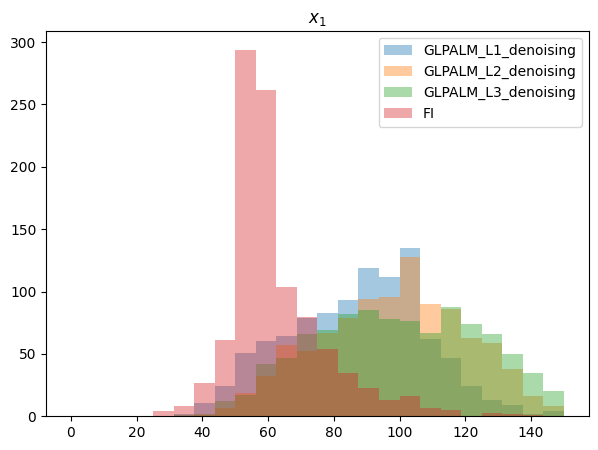

In [15]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig=0.1
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
plt.figure(figsize=(7,5))
for fname in ['model_GLPALM_L1_denoising',
             'model_GLPALM_L2_denoising',
             'model_GLPALM_L3_denoising']:
    model = GLPALM.load_model('Models/'+fname, device=device)
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    model_name = fname[fname.find('GLPALM'):]
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
    
print('FI:')
Apred_FI = []
Xpred_FI = []

for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()

    for _ in range(0):
        PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Xpred).float())
        B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
        Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))


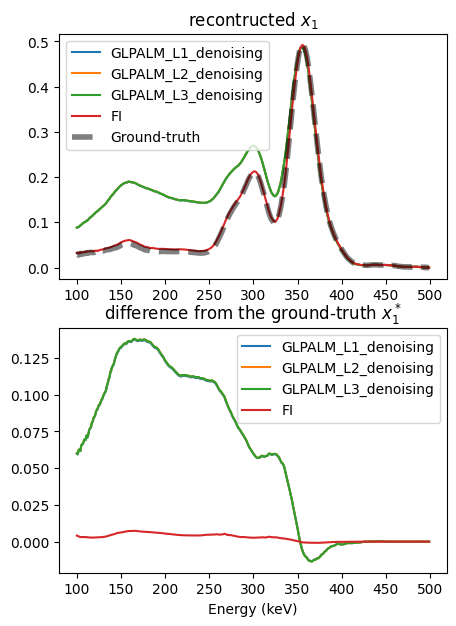

In [36]:
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 10, noise_level=[1e-3,1e-1],sigma_a=0.1)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
plt.figure(figsize=(5,7))
for fname in ['model_GLPALM_L1_denoising',
             'model_GLPALM_L2_denoising',
             'model_GLPALM_L3_denoising']:
    model = GLPALM.load_model('Models/'+fname, device=device)
    model_name = fname[fname.find('GLPALM'):]
    #prediction GLPALM
    Apred, Lam_pred = model.forward(Y.to(device))
    Apred = Apred[-1].cpu().detach().numpy()
    Xpred = model.psi(Lam_pred[-1]).cpu().detach().numpy()
    #prediction FI
    Xpred3=np.zeros(Xtest.shape)
    for j in range(Xtest.shape[1]):
        PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
        B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
        Xpred3[:,j]=model_IAE_list[j].decode(B).detach().numpy()

    i = 0

    energy=np.arange(100,500)
    for j in range(Xtest.shape[1]):
        plt.subplot(2,Xtest.shape[1],j+1)
        plt.plot(energy,Xpred[i,j,:,0].T,label=model_name)  
        plt.legend()
        plt.title('recontructed $x_%d$'%(j+1))
        plt.subplot(2,Xtest.shape[1],j+1+Xtrain.shape[1])
        plt.plot(energy,Xpred[i,j,:,0].T-Xtest[i,j,:,0].T,label=model_name)
        plt.title('difference from the ground-truth $x_%d^*$'%(j+1))
        plt.xlabel('Energy (keV)')
plt.subplot(2,Xtest.shape[1],j+1)
plt.plot(energy,Xpred3[i,j,:,0].T,label='FI')  
plt.plot(energy,Xtest[i,j,:,0].T,label='Ground-truth',lw=4,alpha=0.5,color='k',linestyle='--')  
plt.legend()
plt.subplot(2,Xtest.shape[1],j+1+Xtrain.shape[1])
plt.plot(energy,Xpred3[i,j,:,0].T-Xtest[i,j,:,0].T,label='FI')
plt.legend()
# plt.savefig('./Figures/.png', bbox_inches='tight')
plt.show()

In [3]:
model = GLPALM.load_model('Models/model_GLPALM_L2_sigma0.1_w0', device=device)
print(model.W.shape)
model.W.squeeze().cpu().detach().numpy().shape
plt.plot(model.W.squeeze().cpu().detach().numpy()[1,2].T)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Models/model_GLPALM_L2_sigma0.1_w0.pth'

### Unmixing

In [3]:
model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3')
]
# sig = 'inf'
# Y,A,X=generate_dataset_mixture(model_IAE_list, 20000, noise_level=[1e-3,1e-1],sigma_a=sig)
# with open('data/mixture_sigma'+str(sig)+'.npy', "wb") as f:
#     pickle.dump([Y,A,X], f)

with open('data/mixture_sigmainf.npy', "rb") as f:
    Y, A, X = pickle.load(f)
idx=16000    
Xtrain = X[:idx]
Ytrain = Y[:idx]
Atrain = A[:idx]
Xval = X[idx:]
Yval = Y[idx:]
Aval = A[idx:]

GLPALM_L2_sigma0.01
médiane de nmse_x:  [64.059845 65.448456 76.403564]
médiane de err_a:  [-4.26449269 -4.56260798 -4.13945488]
FI:
médiane de nmse_x: 50.35 dB
médiane de nmse_x: 44.51 dB
médiane de nmse_x: 56.61 dB


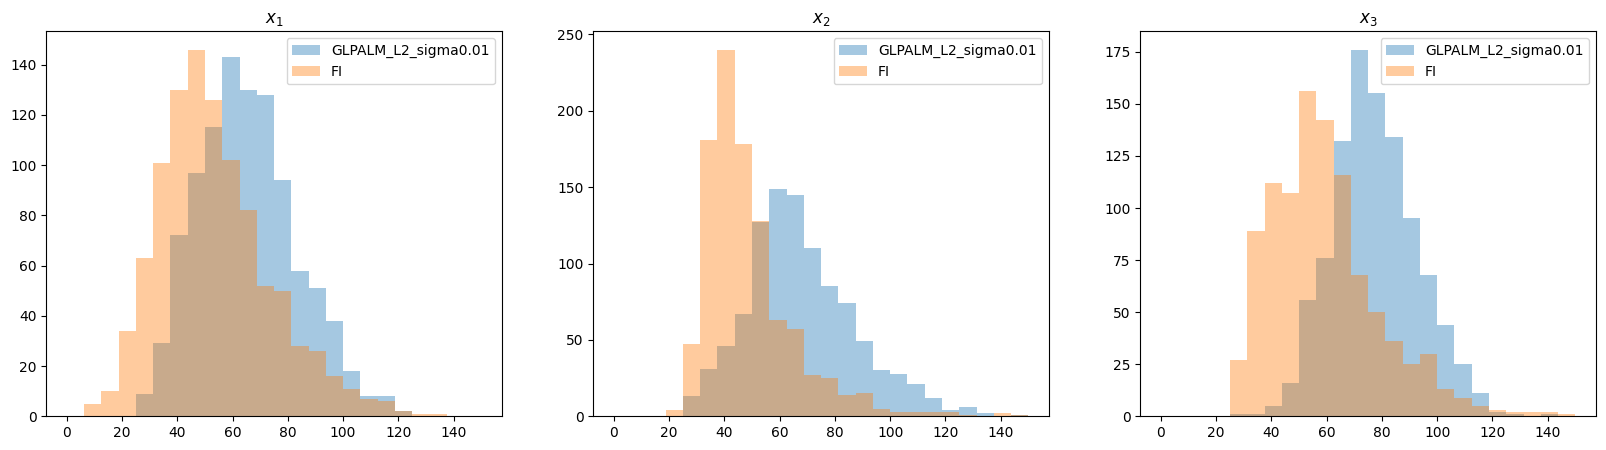

In [4]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig=0.01
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

plt.figure(figsize=(20,5))
for fname in ['Models/models0712/model_GLPALM_L2_sigma0.01']:
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLPALM'):]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))

    for j in range(Xtest.shape[1]):
        plt.subplot(1,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  

    
print('FI:')
Apred_FI = []
Xpred_FI = []

for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))


/tmp/ipykernel_177509/2811775496.py:25: RuntimeWarning: divide by zero encountered in divide
  err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())


GLPALM_L2_sigma0.1
médiane de nmse_x:  [54.662445 60.40052  67.77348 ]
médiane de err_a:  [-3.74074348 -4.16697548 -3.66896359]
FI:
médiane de nmse_x: 31.32 dB
médiane de nmse_x: 44.53 dB
médiane de nmse_x: 54.76 dB


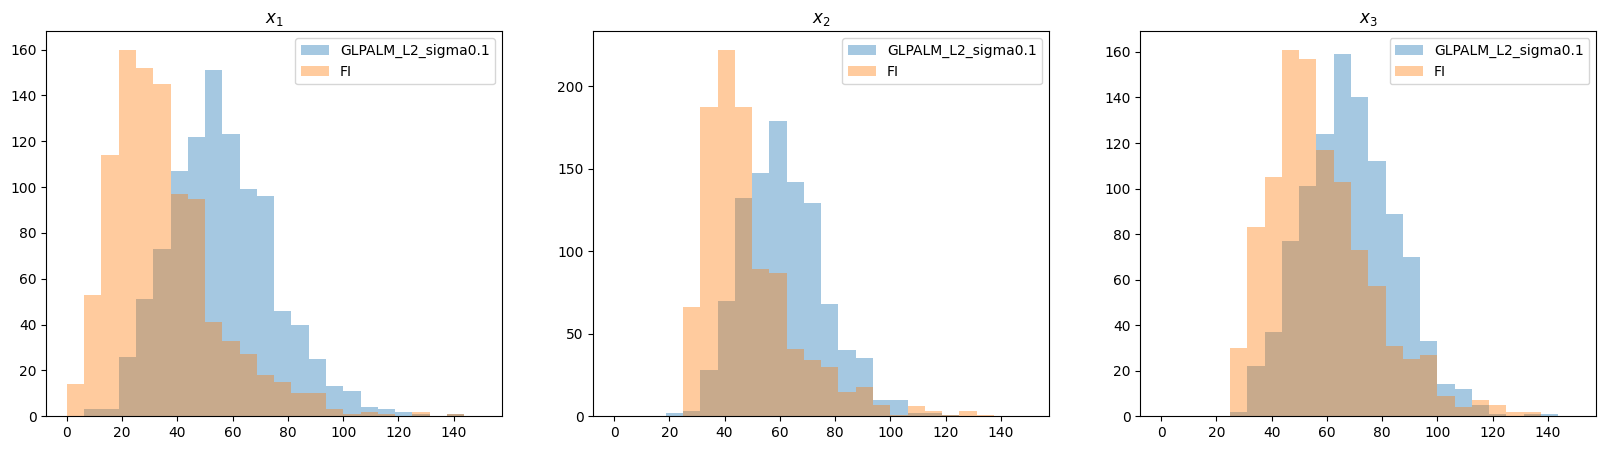

In [7]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig=0.1
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

plt.figure(figsize=(20,5))
for fname in ['Models/model_GLPALM_L2_sigma0.1']:
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLPALM'):]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))

    for j in range(Xtest.shape[1]):
        plt.subplot(1,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  

    
print('FI:')
Apred_FI = []
Xpred_FI = []

for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))


/tmp/ipykernel_2837489/2526990993.py:25: RuntimeWarning: divide by zero encountered in divide
  err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
/tmp/ipykernel_2837489/2526990993.py:25: RuntimeWarning: invalid value encountered in divide
  err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())


GLPALM_LS_L5_sigmainf_WL_uniform
médiane de nmse_x:  [55.740612 66.46433  68.01515 ]
médiane de err_a:  [        nan         nan -3.60650533]
FI:
médiane de nmse_x: 24.83 dB
médiane de nmse_x: 46.90 dB
médiane de nmse_x: 51.96 dB


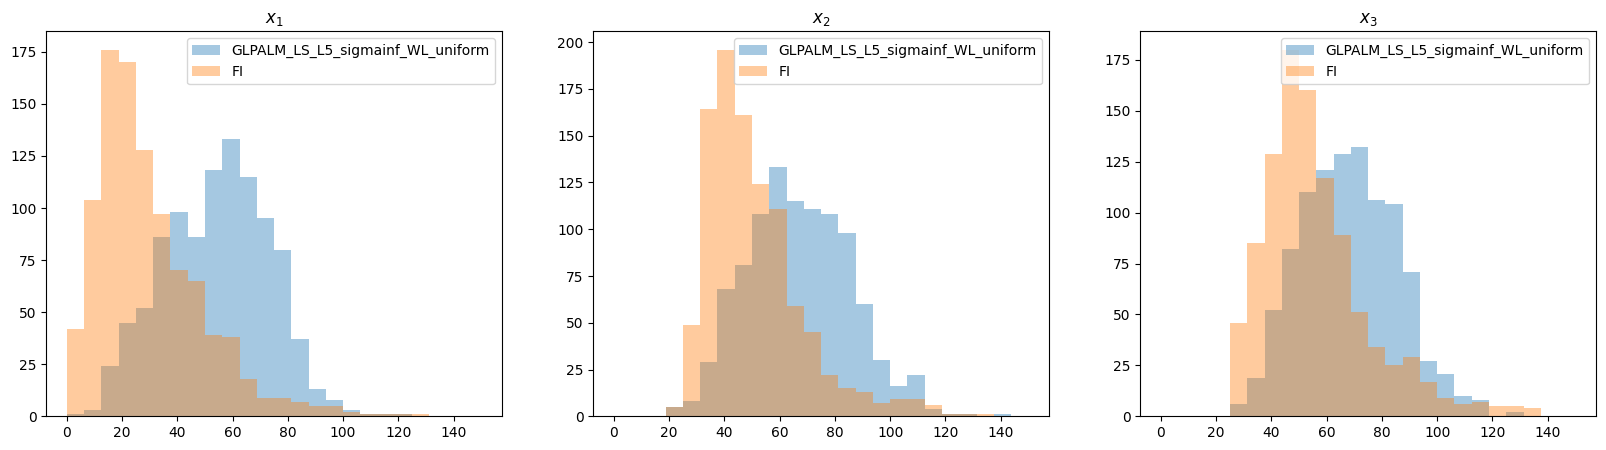

In [58]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig='inf'
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

plt.figure(figsize=(20,5))
for fname in ['Models/model_GLPALM_LS_L5_sigmainf_WL_uniform']:
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLPALM'):]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)

    nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
    err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())
    
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x,0))
    print('médiane de err_a: ',np.median(err_a,0))

    for j in range(Xtest.shape[1]):
        plt.subplot(1,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  

    
print('FI:')
Apred_FI = []
Xpred_FI = []

for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))


GLPALM
médiane de nmse_x:  [63.435116 63.655975 75.25835 ]
médiane de err_a:  [-4.38418702 -4.61894289 -4.04303859]
LPALM
médiane de nmse_x:  [48.37306  67.620255 57.231354]
médiane de err_a:  [-3.42480395 -3.86686371 -3.24817761]
FI:
médiane de nmse_x: 48.87 dB
médiane de nmse_x: 43.91 dB
médiane de nmse_x: 57.42 dB


<Figure size 2000x500 with 0 Axes>

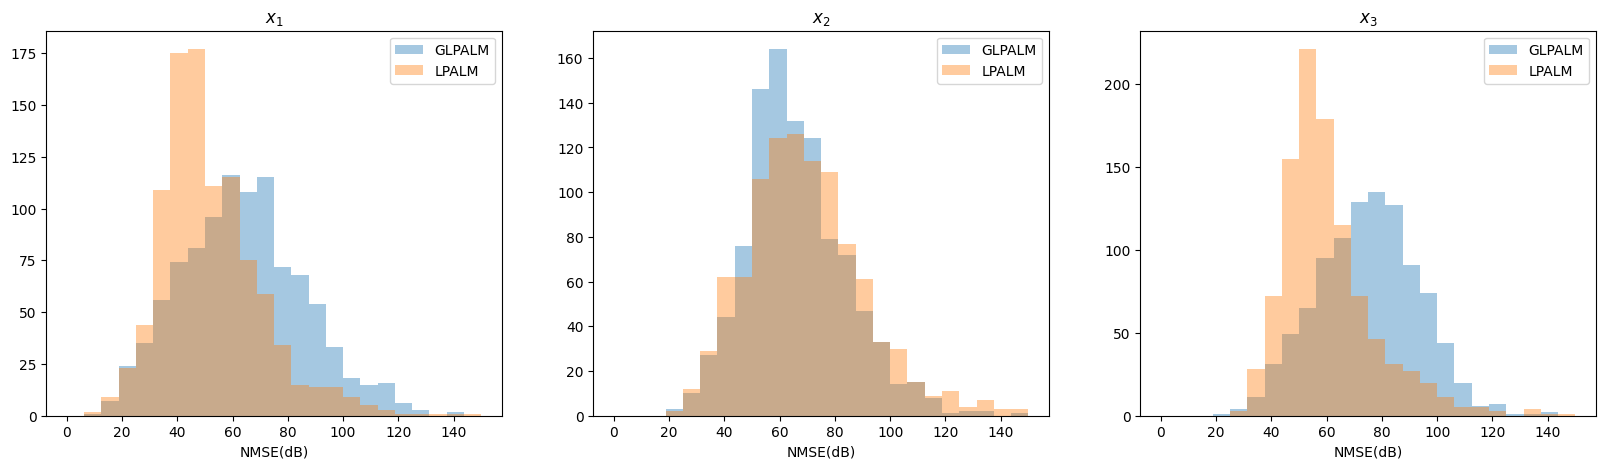

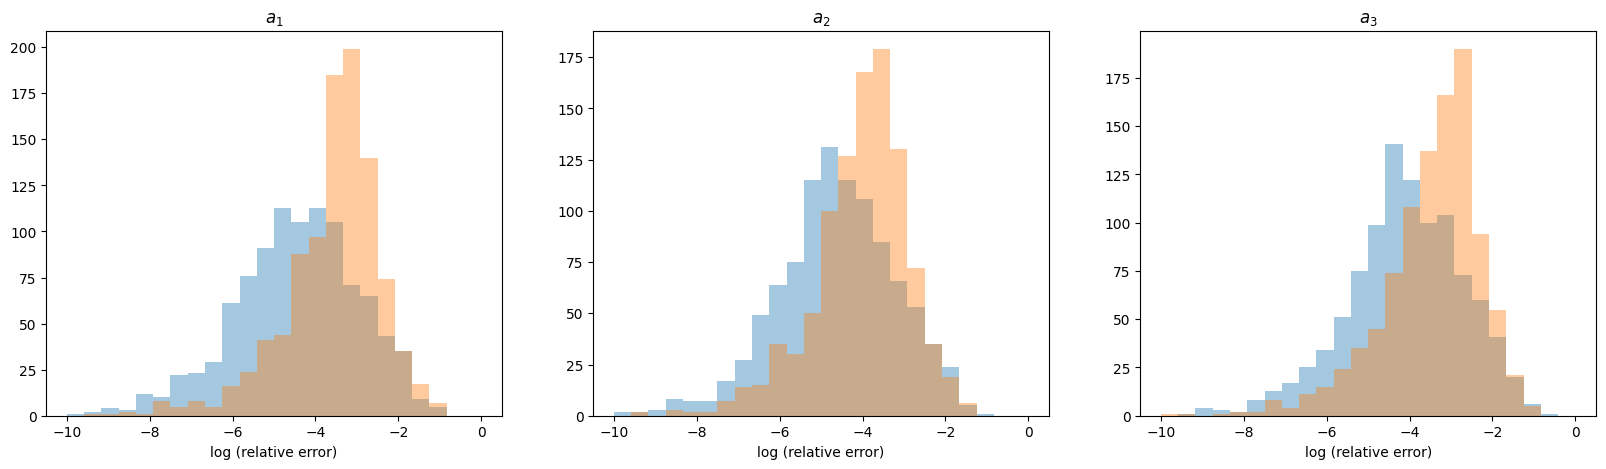

In [10]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig=0.01
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

plt.figure(figsize=(20,5))

# GLPALM
model = GLPALM.load_model('Models/model_GLPALM_LS_CNN_L6_sigma0.1', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)
Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)

nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())

print('GLPALM')
print('médiane de nmse_x: ',np.median(nmse_x,0))
print('médiane de err_a: ',np.median(err_a,0))

    
# LPALM
model = LPALM_mix.load_model('Models/models0712/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Xpred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)

Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)
    

nmse_x2 = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a2 = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())

print('LPALM')
print('médiane de nmse_x: ',np.median(nmse_x2,0))
print('médiane de err_a: ',np.median(err_a2,0))

    
print('FI:')
Apred_FI = []
Xpred_FI = []

plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='GLPALM')
    plt.hist(nmse_x2[:,j],bins_x,alpha=0.4,label='LPALM')
    # plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.xlabel('NMSE(dB)')
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
plt.savefig('./Figures/GLPALM_LPALM_FI_x_sigma0.01.png', bbox_inches='tight')


plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a2[:,j],bins_a,alpha=0.4,label='LPALM')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
plt.savefig('./Figures/GLPALM_LPALM_FI_a_sigma0.01.png', bbox_inches='tight')

GLPALM
médiane de nmse_x:  [55.760323 61.956425 67.53081 ]
médiane de err_a:  [-3.80344671 -4.23071192 -3.66218425]
LPALM
médiane de nmse_x:  [47.261963 66.19488  57.665886]
médiane de err_a:  [-3.37672893 -3.99318991 -3.29861802]
FI:
médiane de nmse_x: 31.06 dB
médiane de nmse_x: 44.99 dB
médiane de nmse_x: 54.63 dB


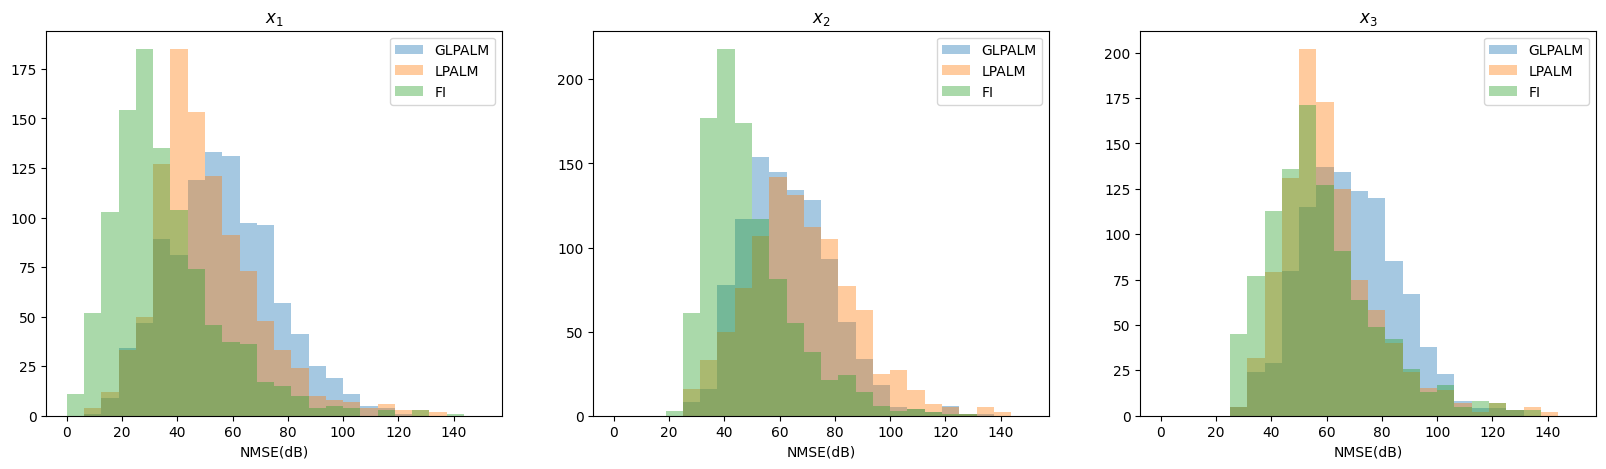

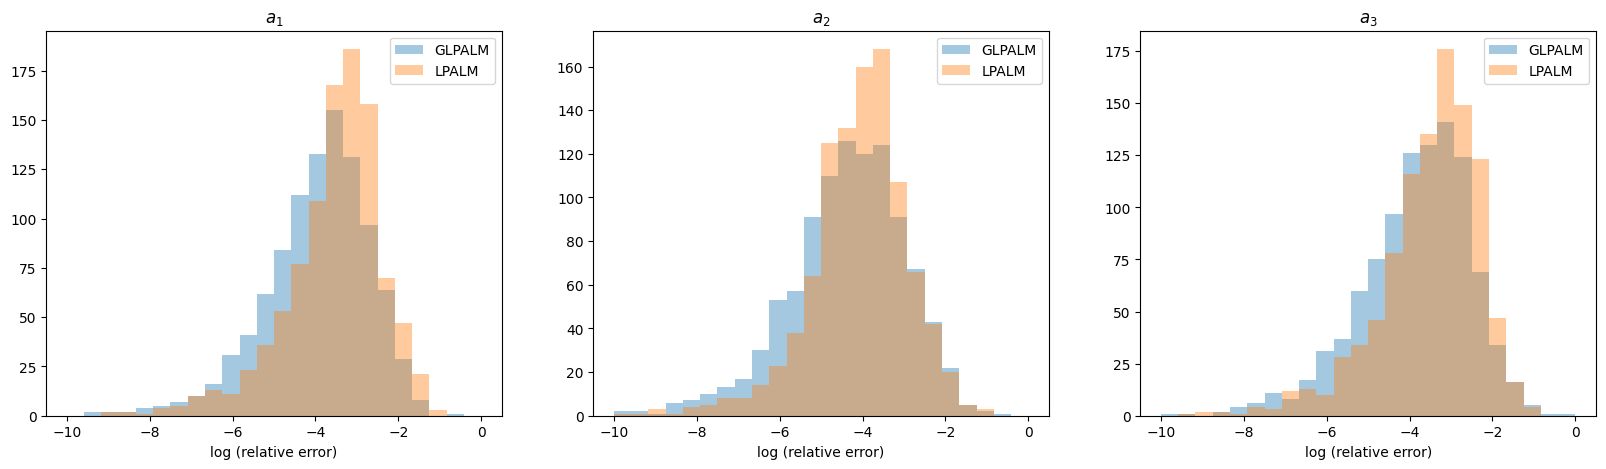

In [60]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig=0.1
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)


# GLPALM
model = GLPALM.load_model('Models/models0712/model_GLPALM_L2_sigma0.1', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)
Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)

nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())

print('GLPALM')
print('médiane de nmse_x: ',np.median(nmse_x,0))
print('médiane de err_a: ',np.median(err_a,0))

    
# LPALM
model = LPALM_mix.load_model('Models/models0712/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Xpred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)

Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)
    

nmse_x2 = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a2 = np.log((np.abs(Apred-Atest)/np.abs(Atest)).squeeze())

print('LPALM')
print('médiane de nmse_x: ',np.median(nmse_x2,0))
print('médiane de err_a: ',np.median(err_a2,0))

print('FI:')
Apred_FI = []
Xpred_FI = []

plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='GLPALM')
    plt.hist(nmse_x2[:,j],bins_x,alpha=0.4,label='LPALM')
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.xlabel('NMSE(dB)')
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
# plt.savefig('./Figures/GLPALM_LPALM_FI_x_sigma0.1.png', bbox_inches='tight')


plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a2[:,j],bins_a,alpha=0.4,label='LPALM')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()
# plt.savefig('./Figures/GLPALM_LPALM_FI_a_sigma0.1.png', bbox_inches='tight')

GLPALM
médiane de nmse_x:  [57.082634 65.83913  68.05719 ]
médiane de err_a:  [-4.99767416 -5.39987503 -4.86191706]
LPALM
médiane de nmse_x:  [25.888847 56.8929   54.640835]
médiane de err_a:  [-3.98230219 -4.678536   -4.03589695]
FI:
médiane de nmse_x: 25.04 dB
médiane de nmse_x: 45.87 dB
médiane de nmse_x: 52.90 dB


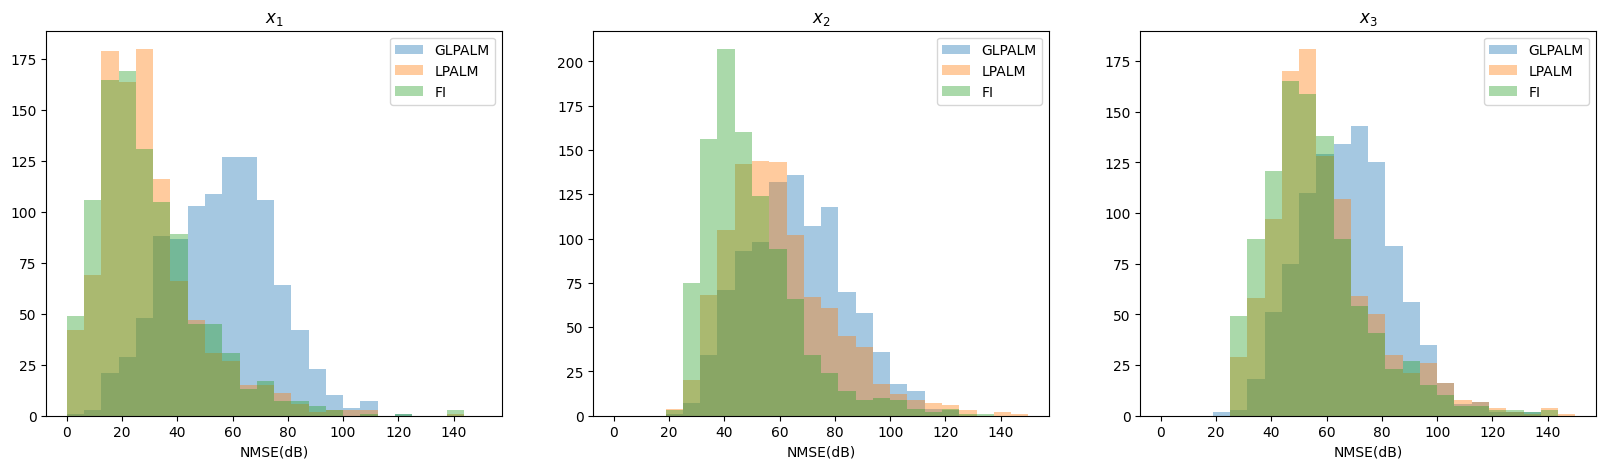

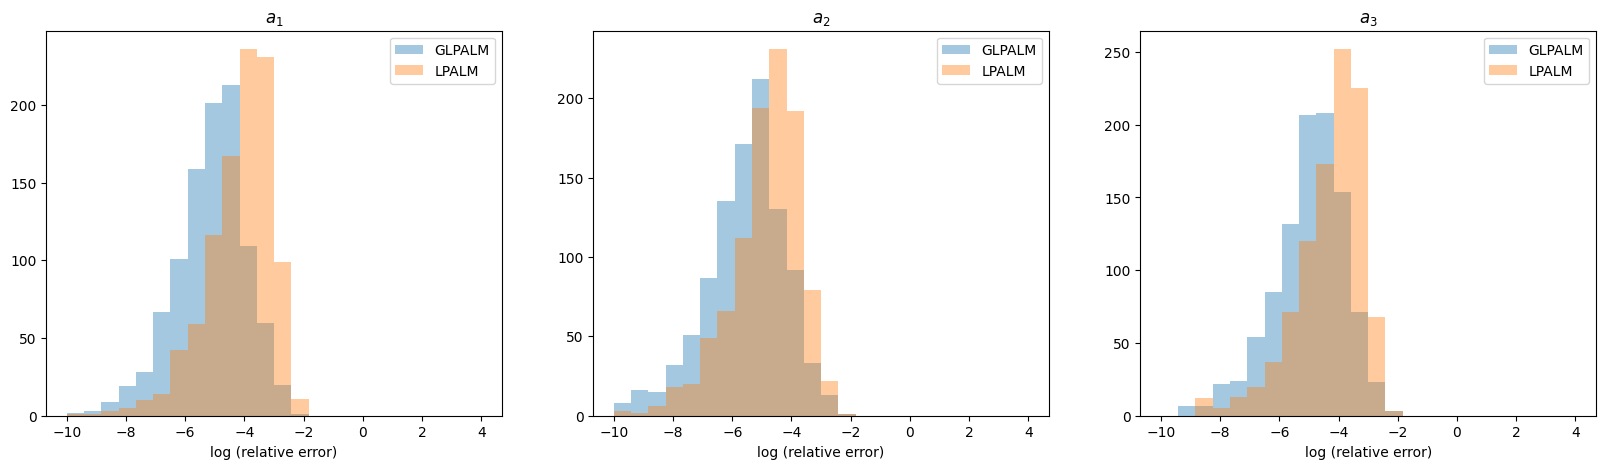

In [26]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 4,25)
        
sig='inf'
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)


# GLPALM
model = GLPALM.load_model('Models/model_GLPALM_LS_L5_sigmainf_WL_uniform', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)
Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)

nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a = np.log(np.abs(Apred-Atest).squeeze()+1e-10)

print('GLPALM')
print('médiane de nmse_x: ',np.median(nmse_x,0))
print('médiane de err_a: ',np.median(err_a,0))

# LPALM
model = LPALM_mix.load_model('Models/models0712/model_LPALM_mix_L5_LS_sigmainf_full-supervised-lam0.0', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Xpred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)

Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)
    

nmse_x2 = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a2 = np.log(np.abs(Apred-Atest).squeeze()+1e-10)

print('LPALM')
print('médiane de nmse_x: ',np.median(nmse_x2,0))
print('médiane de err_a: ',np.median(err_a2,0))

# for j in range(Xtest.shape[1]):
#     plt.subplot(1,Xtest.shape[1],j+1)

    
print('FI:')
Apred_FI = []
Xpred_FI = []

plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='GLPALM')
    plt.hist(nmse_x2[:,j],bins_x,alpha=0.4,label='LPALM')
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.xlabel('NMSE(dB)')
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
# plt.savefig('./Figures/GLPALM_LPALM_FI_x_sigmainf.png', bbox_inches='tight')


plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a2[:,j],bins_a,alpha=0.4,label='LPALM')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()
# plt.savefig('./Figures/GLPALM_LPALM_FI_a_sigmainf.png', bbox_inches='tight')

In [9]:
model = GLPALM.load_model('Models/model_GLPALM_LS_CNN_L4_sigma0.1_scaling0.1', device=device)
print(model)

GLPALM(
  (W1_l1): Sequential(
    (0): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (1): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (2): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (3): Linear(in_features=5, out_features=2, bias=False)
  )
  (W2_l1): Sequential(
    (0): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (1): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (2): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (3): Linear(in_features=5, out_features=2, bias=False)
  )
  (W3_l1): Sequential(
    (0): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (1): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (2): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (3): Linear(in_features=5, out_features=2, bias=False)
  )
  (W1_l2): Sequential(
    (0): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=False)
    (1): Conv1d(1, 1, kernel_size=(7,), stride=(4,), bias=Fal

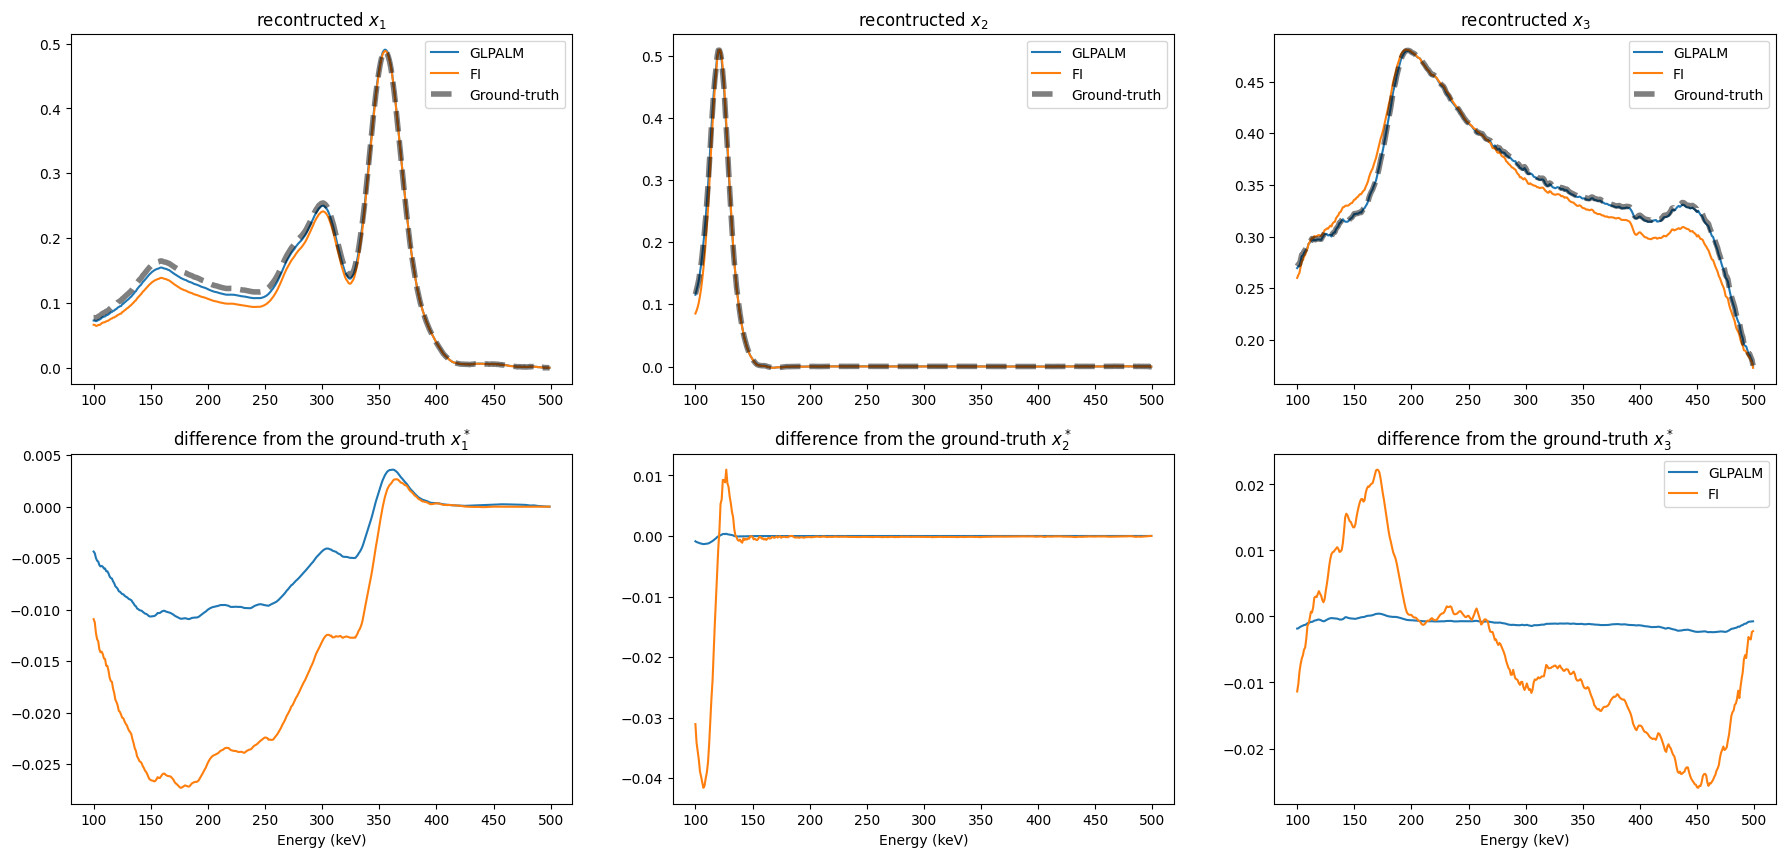

In [15]:
# Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 10, noise_level=[1e-3,1e-1],sigma_a=0.1)
# # dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
# model = GLPALM.load_model('Models/model_GLPALM_L4_GD_sigma0.1_WL_linear', device=device)
# #prediction GLPALM
# Apred, Lam_pred = model.forward(torch.tensor(Ytest).float().to(device))
# Apred = Apred[-1].cpu().detach().numpy()
# Xpred = model.psi(Lam_pred[-1]).cpu().detach().numpy()
# #prediction FI
# Xpred3=np.zeros(Xtest.shape)
# for j in range(Xtest.shape[1]):
#     PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
#     B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
#     Xpred3[:,j]=model_IAE_list[j].decode(B).detach().numpy()
i=4
plt.figure(figsize=(22,10))
energy=np.arange(100,500)
for j in range(3):
    plt.subplot(2,3,j+1)
    plt.plot(energy,Xpred[i,j,:,0].T,label='GLPALM')  
    plt.plot(energy,Xpred3[i,j,:,0].T,label='FI')  
    plt.plot(energy,Xtest[i,j,:,0].T,label='Ground-truth',lw=4,alpha=0.5,color='k',linestyle='--')  
    plt.legend()
    plt.title('recontructed $x_%d$'%(j+1))
    plt.subplot(2,Xtest.shape[1],j+1+Xtrain.shape[1])
    plt.plot(energy,Xpred[i,j,:,0].T-Xtest[i,j,:,0].T,label='GLPALM')
    plt.plot(energy,Xpred3[i,j,:,0].T-Xtest[i,j,:,0].T,label='FI')
    plt.title('difference from the ground-truth $x_%d^*$'%(j+1))
    plt.xlabel('Energy (keV)')
plt.legend()
# plt.savefig('./Figures/.png', bbox_inches='tight')
plt.show()

GLPALM_LS_L5_sigmainf_WL_uniform
médiane de nmse_x:  [55.365276 68.025345 68.26874 ]
médiane de err_a:  [-4.97704024 -5.37457633 -4.79153177]
GLPALM_LS_L2_sigmainf
médiane de nmse_x:  [50.97489 65.65299 65.32022]
médiane de err_a:  [-4.85404942 -5.29769387 -4.70767272]
FI:
médiane de nmse_x: 24.89 dB
médiane de nmse_x: 46.22 dB
médiane de nmse_x: 52.00 dB


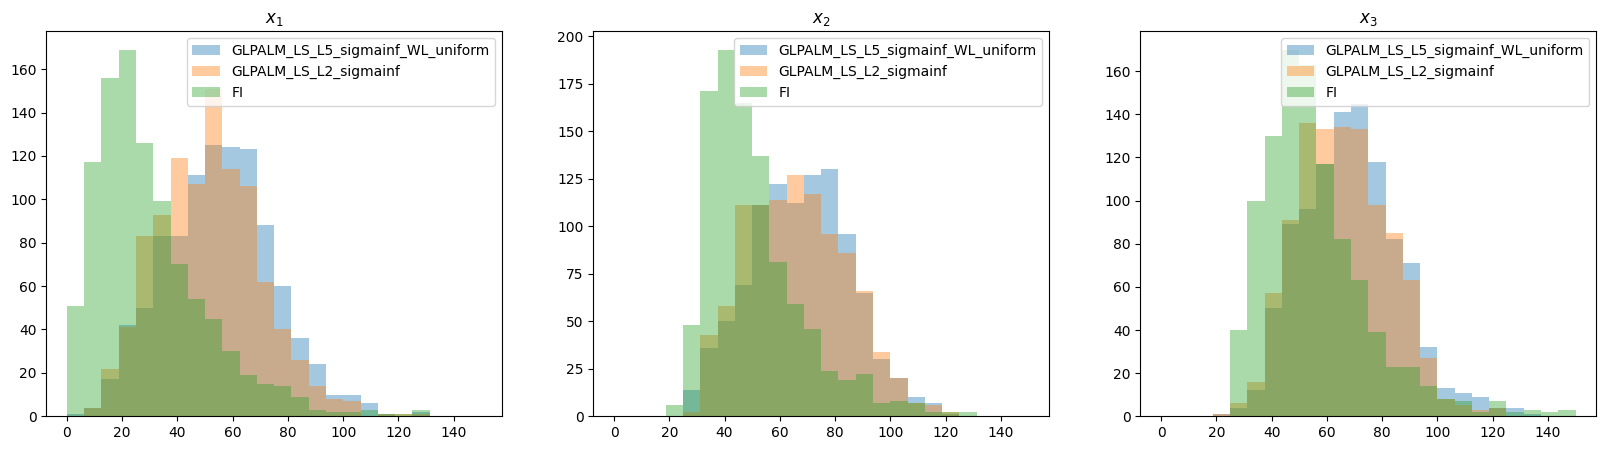

In [63]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig='inf'
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
nmse_x=[]
err_a=[]
plt.figure(figsize=(20,5))
for fname in ['Models/model_GLPALM_LS_L5_sigmainf_WL_uniform',
             'Models/model_GLPALM_LS_L2_sigmainf']:
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLPALM'):]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)

    nmse_x.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
    err_a.append(np.log(np.abs(Apred-Atest).squeeze()+1e-10))
#     err_a = np.log((np.abs(Apred-Atest)/(np.abs(Atest)+1e-10)).squeeze())
    
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x[-1],0))
    print('médiane de err_a: ',np.median(err_a[-1],0))

    for j in range(Xtest.shape[1]):
        plt.subplot(1,Xtest.shape[1],j+1)
        plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label=model_name)  
        plt.legend()

    
print('FI:')
Apred_FI = []
Xpred_FI = []

for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))

plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a2[:,j],bins_a,alpha=0.4,label='LPALM')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()

In [4]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 4,25)
        
sig=0.1
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)


# GLPALM
model = GLPALM.load_model('Models/model_GLPALM_LS_L5_sigmainf_WL_uniform', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)
Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)

nmse_x = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a = np.log((np.abs(Apred-Atest)/(np.abs(Atest)+1e-10)).squeeze())

print('GLPALM')
print('médiane de nmse_x: ',np.median(nmse_x,0))
print('médiane de err_a: ',np.median(err_a,0))
    
# LPALM
model = LPALM_mix.load_model('Models/models0712/model_LPALM_mix_L5_LS_sigma0.1_full-supervised-lam0.0', device=device)
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Xpred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = Xpred_batch[-1].cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)

Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)
    

nmse_x2 = -20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3)))
err_a2 = np.log((np.abs(Apred-Atest)/(np.abs(Atest)+1e-10)).squeeze())

print('LPALM')
print('médiane de nmse_x: ',np.median(nmse_x2,0))
print('médiane de err_a: ',np.median(err_a2,0))
    
print('FI:')
Apred_FI = []
Xpred_FI = []

plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
    B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
    Xpred = model_IAE_list[j].decode(B).detach().numpy()
    nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x[:,j],bins_x,alpha=0.4,label='GLPALM')
    plt.hist(nmse_x2[:,j],bins_x,alpha=0.4,label='LPALM')
    plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
    plt.title('$x_%d$'%(j+1))
    plt.xlabel('NMSE(dB)')
    plt.legend()
    print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
# plt.savefig('./Figures/GLPALM_LPALM_FI_x_sigmainf_WL.png', bbox_inches='tight')


plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a2[:,j],bins_a,alpha=0.4,label='LPALM')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()
# plt.savefig('./Figures/GLPALM_LPALM_FI_a_sigmainf_WL.png', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'Models/model_GLPALM_LS_L5_sigmainf_WL_uniform.pth'

### Version with convolution layers

In [9]:
W_conv = []
ch=1
W_conv.append(torch.nn.Conv1d(ch, ch, kernel_size=7, stride=4, bias=False))
W_conv.append(torch.nn.Conv1d(ch, ch, kernel_size=7, stride=4, bias=False))
W_conv.append(torch.nn.Conv1d(ch, ch, kernel_size=7, stride=4, bias=False))
W_conv.append(torch.nn.Linear(5,2, bias=False))
W_conv = torch.nn.Sequential(*W_conv)
W_conv(torch.rand((32,1,400))).shape

torch.Size([32, 1, 2])

In [15]:
fname ='Models/models0712/model_GLPALM_L2_sigma0.1'
fname[fname.find('GLPALM'):fname.find('_L')]

'GLPALM'

GLPALM
médiane de nmse_x:  [55.15869  61.167446 67.321106]
médiane de err_a:  [-4.80333921 -5.23813037 -4.70637502]
GLPALM_CNN
médiane de nmse_x:  [59.517616 64.07633  71.55832 ]
médiane de err_a:  [-5.31206095 -5.56512466 -5.01896781]


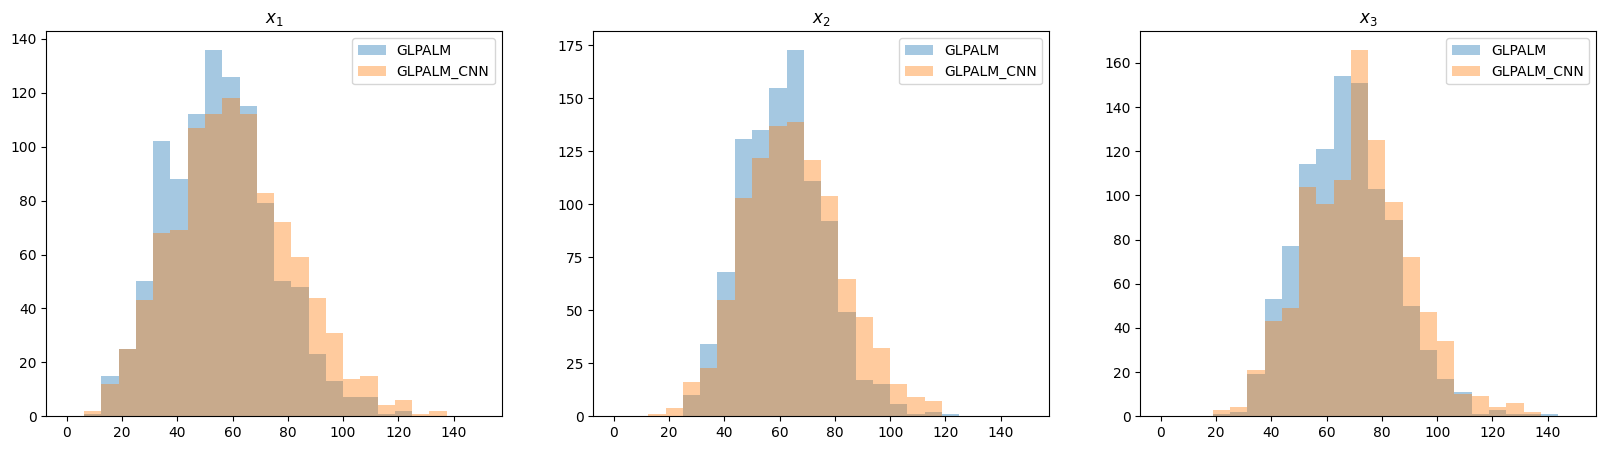

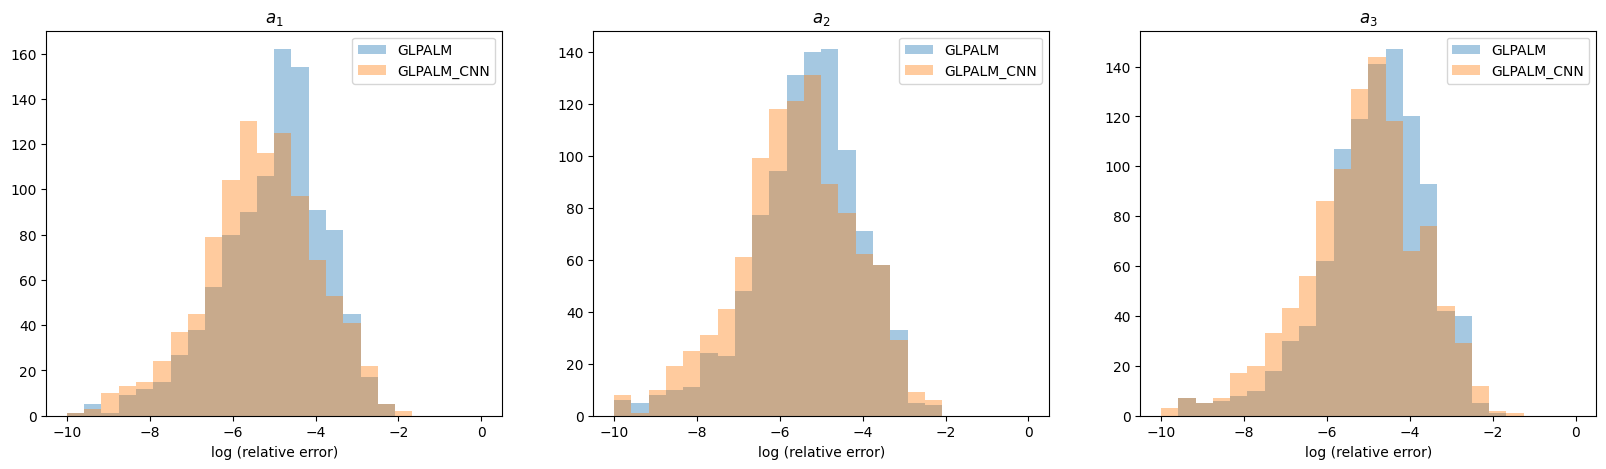

In [5]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig=0.1
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
nmse_x=[]
err_a=[]
plt.figure(figsize=(20,5))
for fname in ['Models/models0712/model_GLPALM_L2_sigma0.1',
             'Models/model_GLPALM_LS_CNN_L6_sigma0.1']:
    model = GLPALM.load_model(fname, device=device)
    model_name = 'GLPALM'
    if 'CNN' in fname:
        model_name = model_name + '_CNN'
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)

    nmse_x.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
    err_a.append(np.log(np.abs(Apred-Atest).squeeze()+1e-10))
#     err_a = np.log((np.abs(Apred-Atest)/(np.abs(Atest)+1e-10)).squeeze())
    
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x[-1],0))
    print('médiane de err_a: ',np.median(err_a[-1],0))

    for j in range(Xtest.shape[1]):
        plt.subplot(1,Xtest.shape[1],j+1)
        plt.hist(nmse_x[-1][:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()

    
# print('FI:')
# Apred_FI = []
# Xpred_FI = []

# for j in range(Xtest.shape[1]):
#     PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
#     B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
#     Xpred = model_IAE_list[j].decode(B).detach().numpy()
#     nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

#     plt.subplot(1,Xtest.shape[1],j+1)
#     plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
#     plt.title('$x_%d$'%(j+1))
#     plt.legend()
#     print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
# plt.savefig('./Figures/GLPALM_CNN_x_sigma0.1.png', bbox_inches='tight')
plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[0][:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a[1][:,j],bins_a,alpha=0.4,label='GLPALM_CNN')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()
# plt.savefig('./Figures/GLPALM_CNN_a_sigma0.1.png', bbox_inches='tight')    

GLPALM
médiane de nmse_x:  [55.37303 66.07403 67.93126]
médiane de err_a:  [-4.94752008 -5.26186907 -4.79427916]
GLPALM_CNN
médiane de nmse_x:  [58.214996 61.049576 69.64242 ]
médiane de err_a:  [-5.1967132  -5.38430592 -4.98920462]


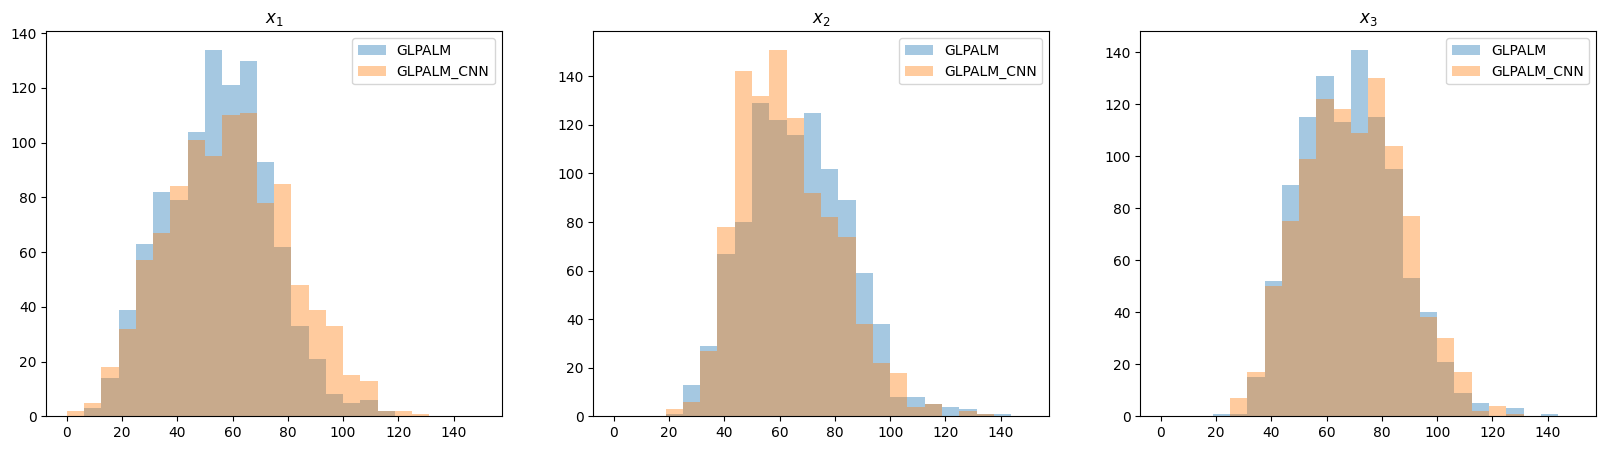

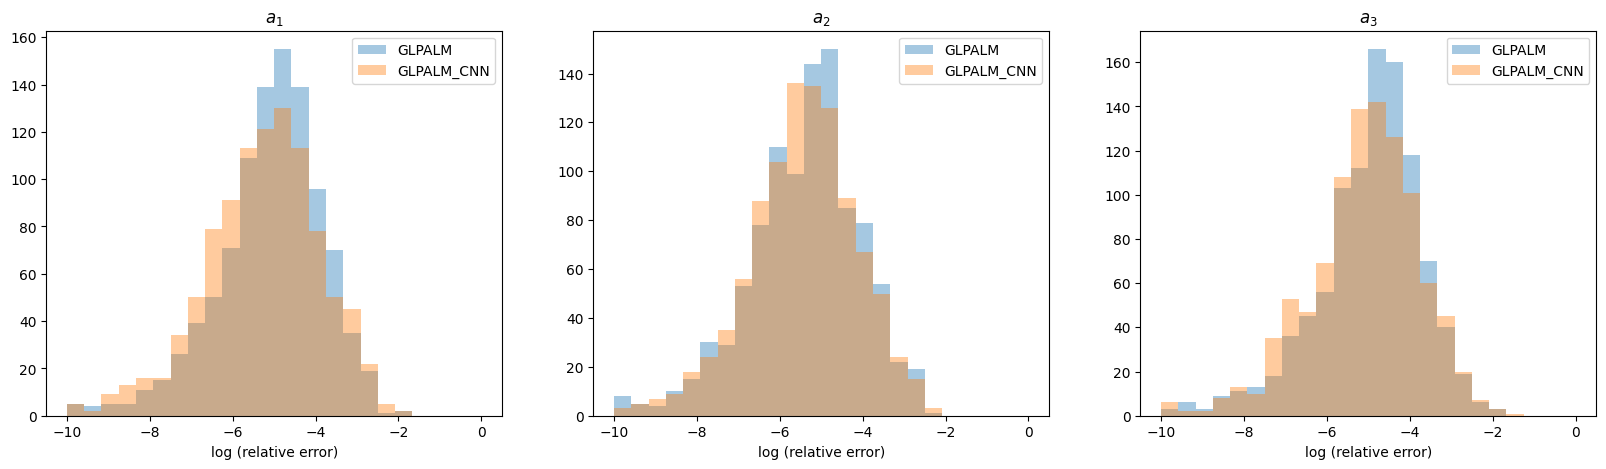

In [7]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
        
sig='inf'
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
nmse_x=[]
err_a=[]
plt.figure(figsize=(20,5))
for fname in ['Models/model_GLPALM_LS_L5_sigmainf_WL_uniform',
             'Models/models0720/model_GLPALM_CNN_LS_L7_sigmainf']:
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLPALM'):fname.find('_L')]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)

    nmse_x.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
    err_a.append(np.log(np.abs(Apred-Atest).squeeze()+1e-10))
#     err_a = np.log((np.abs(Apred-Atest)/(np.abs(Atest)+1e-10)).squeeze())
    
    print(model_name)
    print('médiane de nmse_x: ',np.median(nmse_x[-1],0))
    print('médiane de err_a: ',np.median(err_a[-1],0))

    for j in range(Xtest.shape[1]):
        plt.subplot(1,Xtest.shape[1],j+1)
        plt.hist(nmse_x[-1][:,j],bins_x,alpha=0.4,label=model_name)  
        plt.title('$x_%d$'%(j+1))
        plt.legend()

    
# print('FI:')
# Apred_FI = []
# Xpred_FI = []

# for j in range(Xtest.shape[1]):
#     PhiX,PhiE = model_IAE_list[j].encode(torch.tensor(Ytest).float())
#     B,_ = model_IAE_list[j].interpolator(PhiX,PhiE)
#     Xpred = model_IAE_list[j].decode(B).detach().numpy()
#     nmse_x_FI = -20*np.log10(((Xpred-Xtest[:,j])**2).sum((1,2))/(Xtest[:,j]**2).sum((1,2)))

#     plt.subplot(1,Xtest.shape[1],j+1)
#     plt.hist(nmse_x_FI,bins_x,alpha=0.4,label="FI")  
#     plt.title('$x_%d$'%(j+1))
#     plt.legend()
#     print('médiane de nmse_x: %.2f dB' %(np.median(nmse_x_FI,0)))
# plt.savefig('./Figures/GLPALM_CNN_x_sigmainf.png', bbox_inches='tight')
plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[0][:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a[1][:,j],bins_a,alpha=0.4,label='GLPALM_CNN')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()
# plt.savefig('./Figures/GLPALM_CNN_a_sigmainf.png', bbox_inches='tight')    

GLPALM
médiane de nmse_x:  [52.704735 64.716965 62.319813]
médiane de err_a:  [-4.97824783 -4.87723311 -4.59501066]
GLPALM
médiane de nmse_x:  [57.792038 64.26619  65.29025 ]
médiane de err_a:  [-5.16049152 -5.10579415 -4.83404711]


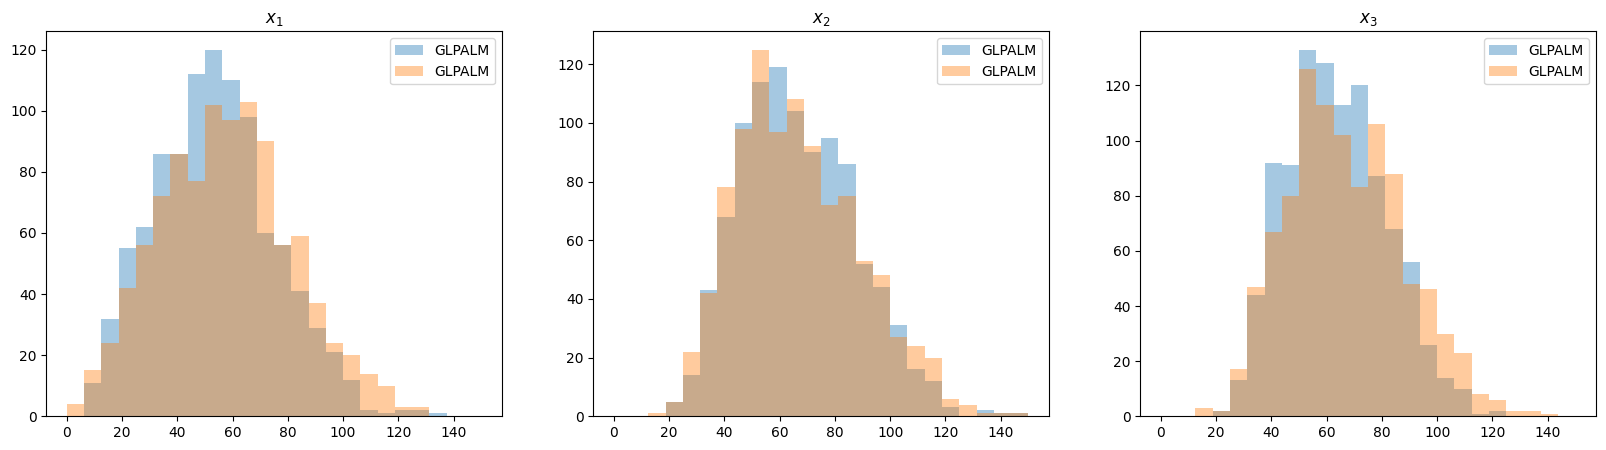

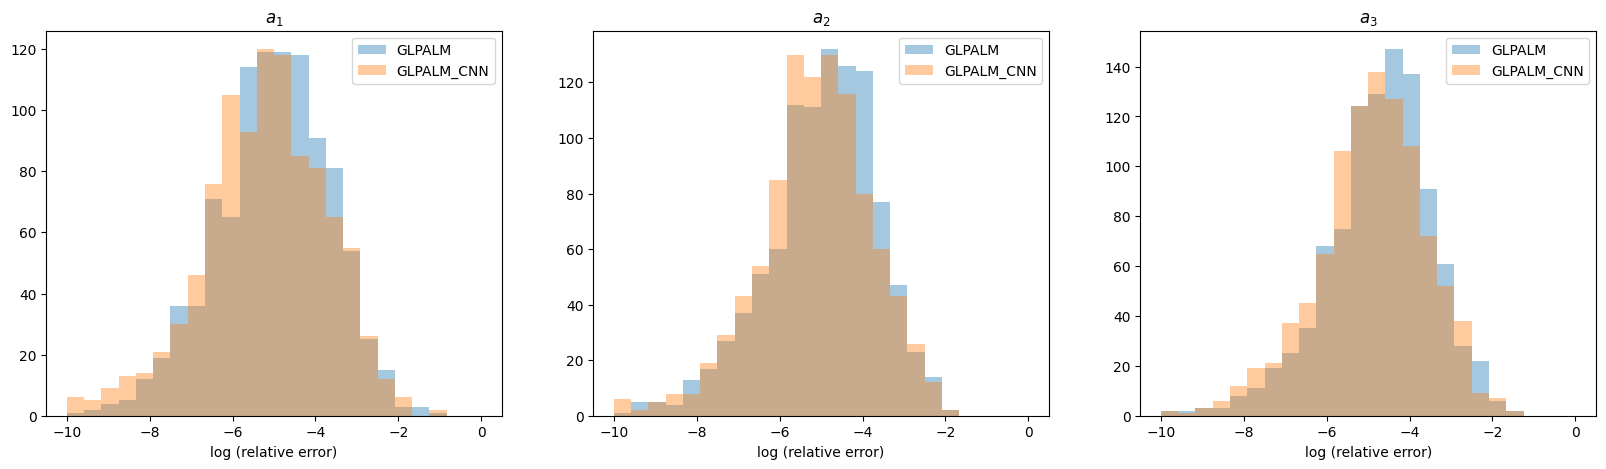

In [6]:
bins_x = np.linspace(0, 150,25)
bins_a = np.linspace(-10, 0,25)
nmse_x=[]
err_a=[]
plt.figure(figsize=(20,5))
       
sig='inf'
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig, eps=1.0)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
fname='Models/models0910/model_GLPALM_LS_CNN_L6_sigmainf_scaling1.0'
model = GLPALM.load_model(fname, device=device)
model_name = fname[fname.find('GLPALM'):fname.find('_L')]
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)
Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)

nmse_x.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
err_a.append(np.log(np.abs(Apred-Atest).squeeze()+1e-10))

print(model_name)
print('médiane de nmse_x: ',np.median(nmse_x[-1],0))
print('médiane de err_a: ',np.median(err_a[-1],0))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x[-1][:,j],bins_x,alpha=0.4,label=model_name)  
    
sig=0.1
Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig, eps=1.0)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
fname='Models/models0910/model_GLPALM_LS_CNN_L10_sigmainf_scaling1.0'
model = GLPALM.load_model(fname, device=device)
model_name = fname[fname.find('GLPALM'):fname.find('_L')]
Apred = []
Xpred = []
for data in dataloader:
    Y,A,X = data
    Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
    Apred_batch = Apred_batch[-1].cpu().detach().numpy()
    Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
    Apred.append(Apred_batch)
    Xpred.append(Xpred_batch)
Apred = np.vstack(Apred)
Xpred = np.vstack(Xpred)

nmse_x.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
err_a.append(np.log(np.abs(Apred-Atest).squeeze()+1e-10))

for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(nmse_x[-1][:,j],bins_x,alpha=0.4,label=model_name)  

plt.figure(figsize=(20,5))
for j in range(Xtest.shape[1]):
    plt.subplot(1,Xtest.shape[1],j+1)
    plt.hist(err_a[0][:,j],bins_a,alpha=0.4,label='GLPALM')
    plt.hist(err_a[1][:,j],bins_a,alpha=0.4,label='GLPALM_CNN')
    plt.title('$a_%d$'%(j+1))
    plt.xlabel('log (relative error)')
    plt.legend()
# plt.savefig('./Figures/GLPALM_CNN_a_sigmainf.png', bbox_inches='tight')    